In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
from numpy.linalg import inv
import scipy.stats as stats
from scipy.optimize import minimize, Bounds, LinearConstraint
from scipy.stats import norm, kurtosis

import pymc3 as pm
import arviz as az
az.style.use("arviz-darkgrid")

In [3]:
file_location = 'C:\\portfolio.csv'

In [4]:
f = pd.read_csv(file_location)
df_port = pd.DataFrame(f)

In [5]:
df_port['Date'] = pd.to_datetime(df_port['Date'], format='%Y-%m-%d')

In [6]:
df_port.set_index('Date', inplace=True)

In [7]:
df_port.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2073 entries, 2020-12-31 to 2013-01-02
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   spx     2073 non-null   float64
 1   us_gov  2073 non-null   float64
 2   eafe    2073 non-null   float64
 3   eu_gov  2073 non-null   float64
 4   credit  2073 non-null   float64
 5   gsci    2073 non-null   float64
 6   em_stx  2073 non-null   float64
 7   em_gov  2073 non-null   float64
 8   ch_gov  2073 non-null   float64
dtypes: float64(9)
memory usage: 162.0 KB


# Feature Engineering

In [8]:
df_port.head(10)

spx    us_gov      eafe    eu_gov    credit      gsci  \
Date                                                                     
2020-12-31  0.006518  0.000958 -0.006456 -0.005229 -0.000099  0.004000   
2020-12-30  0.001451  0.000607  0.001109  0.004484  0.002481  0.007775   
2020-12-29 -0.002225 -0.000188  0.012156  0.007942  0.002109  0.007100   
2020-12-28  0.008722  0.000063  0.007487  0.000000  0.000761 -0.007006   
2020-12-24  0.003643  0.001520  0.002207 -0.000194  0.001339  0.000324   
2020-12-23  0.000762 -0.002295  0.009993 -0.002351 -0.000541  0.014686   
2020-12-22 -0.001997  0.001751 -0.000790 -0.002922  0.000177 -0.008680   
2020-12-21 -0.003875  0.000721 -0.017553 -0.001411 -0.001244 -0.014307   
2020-12-18 -0.003439 -0.001085 -0.004514 -0.001601 -0.001199  0.008670   
2020-12-17  0.005805 -0.000630  0.008558  0.005277  0.002336  0.010954   

              em_stx    em_gov    ch_gov  
Date                                      
2020-12-31  0.001733 -0.000907 -0.001293  
2020-12-30  0.017573  0.002532  0.001365  
2020-12-29  0.012686  0.003475  0.001890  
2020-12-28 -0.000942 -0.001591  0.000373  
2020-12-24 -0.003589  0.002786  0.000568  
2020-12-23  0.007581  0.000915  0.001957  
2020-12-22 -0.006592 -0.001208  0.002047  
2020-12-21 -0.008934 -0.007605 -0.000096  
2020-12-18 -0.003580 -0.001064 -0.001127  
2020-12-17  0.007559  0.008018  0.000361

### Capital market assumptions

In [9]:
# Optimization inputs, in particular the portfolio covariance matrix
factor_moments = pd.DataFrame(np.mean(df_port, axis=0), columns=['return'])
factor_moments['volatility'] = np.diag(df_port.cov())**0.5*(253**0.5) #253 trading days in year
cov =  df_port.cov()

In [10]:
ecov_all = np.array(cov)

In [11]:
# Enter expected variances, which are annualized standard deviations divided by square root of 253
expected_variance = [0.0001169328, 0.0000119565, 0.0001076087, 0.0000115257, 0.0000115257, 
                     0.0001024545, 0.0001793241, 0.0000278893, 0.0000063241]

In [12]:
np.fill_diagonal(ecov_all, expected_variance)

In [13]:
# Expected returns in the order of the df_port's column headings
expected_returns = np.array([[ 0.063],  # US equities
                             [ 0.007],  # US bonds
                             [ 0.075],  # EAFE equities
                             [-0.004],  # EU bonds
                             [ 0.0025], # Credit
                             [ 0.023],  # Commodities
                             [ 0.072],  # EM equities
                             [ 0.034],  # EM bonds
                             [ 0.031]]) # China bonds

In [14]:
# Hypothetical initial asset class weights for a global investor
ini_weights = [0.25, 0.20, 0.15, 0.10, 0.05, 0.05, 0.10, 0.07, 0.03]

# Optimization Code

In [15]:
# Function to generate portfolio returns, variance and standard deviation, utilizing DataFrames
# weights is a vector of asset weights
# exp_returns is a vector of asset expected returns
# @ denotes matrix multiplication
def port_profile(weights, exp_returns, cov):
    port_return = weights.T@exp_returns                       # compute the portfolio's expected returns
    port_var = weights.T@cov@weights                          # compute the portfolio's variance
    port_vol = port_var**0.5*(253**0.5)                       # annualised standard deviation
    return port_return.values.item(0), port_vol.values.item(0)# extract single value from DF

In [16]:
# Set four constraints, one for Developed Market equity allocation,
# one for EM equity allocation, 
# one for DM bond allocation, and
# one for EM bond allocation 
# The first two equality constraints are taken from Blackrock's hypothetical "UK multi-asset" fund (Feb 2021)
dm_equities = 0.46
em_equities = 0.07
dm_bonds = 0.20
em_bonds = 0.15  #max inequality constraint

In [17]:
# Set portfolio target expected return, also for the hypothetical "UK multi-asset" fund
target_return = 0.045

In [18]:
# Fuction to optimise is the expected return divided by the portfolio standard deviation
def ret_risk(W, E, cov):
    return -((W.T@E) / (W.T@cov@W)**0.5)

In [19]:
# Portfolio optimization function
def optimizer(func, W, E, cov, target_return):
    # Portfolio bounds for each asset class
    port_bounds = Bounds(0.0, 1.0)
    
    port_constraints = ({'type': 'eq',
                        'fun': lambda W: W[0] + W[2] - dm_equities},# DM equities allocation
                        {'type': 'ineq',
                        'fun': lambda W: dm_bonds - (W[1] + W[3])}, # Maximum DM bonds allocation
                        {'type': 'ineq',
                        'fun': lambda W: W[0] - 0.15},              # Minimum US equity allocation of 15%
                        {'type': 'eq',
                        'fun': lambda W: W[6] - em_equities},       # EM equities allocation
                        {'type': 'ineq',
                        'fun': lambda W: em_bonds - (W[7] + W[8])}, # Maximum EM bonds allocation
                        {'type': 'ineq',
                        'fun': lambda W: 0.05 - W[8]},              # Maximum China bond allocation of 5%
                        {'type': 'eq',
                        'fun': lambda W: np.sum(W) - 1.0},          # Weights of all assets must equal 100%
                        {'type': 'eq',
                        'fun': lambda W: W.T@E - target_return})    # Portfolio return equals the "target return"
    opt_weights = minimize(func, 
                            W, 
                            args=(E, cov),
                            method='SLSQP',
                            bounds=port_bounds,
                            constraints=port_constraints)
    
    return opt_weights['x']


# Optimization

In [20]:
# Run optimizer to return an array of the optimized weights as "x"
x = optimizer(ret_risk, ini_weights, expected_returns, ecov_all, target_return)

In [21]:
opt = pd.DataFrame(x, index=factor_moments.index, columns=['optimal_weights'])

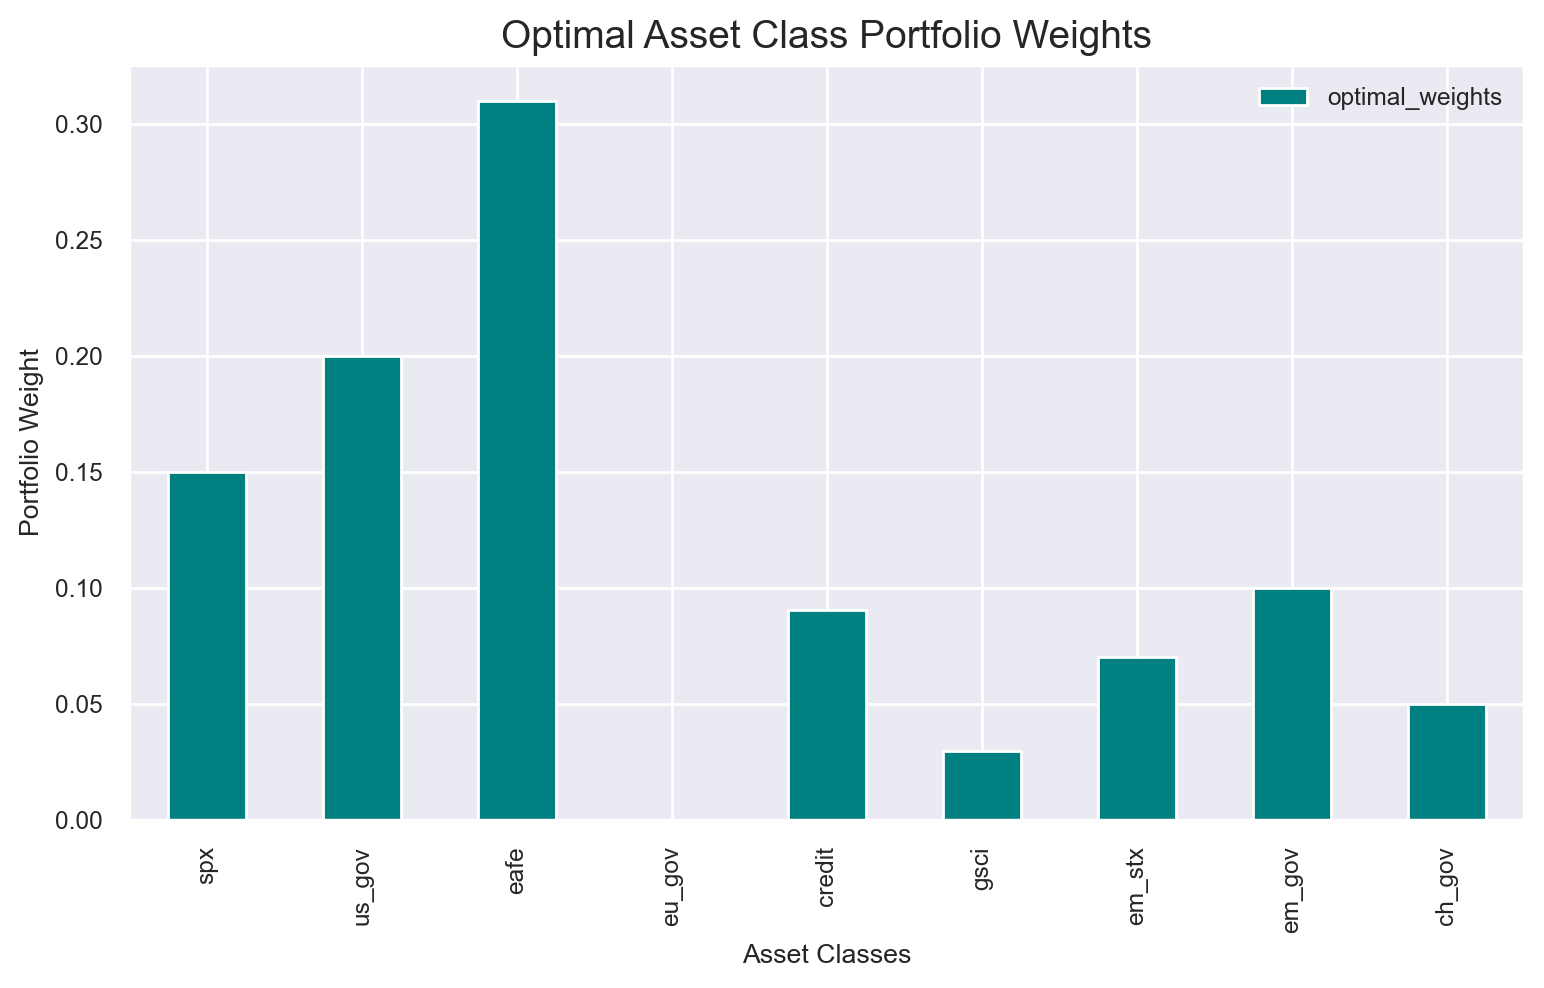

In [22]:
sns.set(font_scale=0.8)
ax = opt.plot(kind='bar', color='teal', figsize=(9, 5))
ax.set_xlabel("Asset Classes")
ax.set_ylabel("Portfolio Weight")
ax.set_title("Optimal Asset Class Portfolio Weights", fontsize=14)
plt.show()

### Dropping EM bonds

In [23]:
# Dropping the China bonds columns from the main DataFrame
df_port_xem = df_port.drop(['ch_gov'], axis=1)

In [24]:
# Setting max allocation to EM bonds of 5%
em_bonds_less = 0.05
dm_bonds_more = 0.20 # Keeping maximum DM bond allocation at 20%

In [25]:
# Drop Chinese bonds returns from the returns array
expected_returns_xem = expected_returns[:-1]

In [26]:
cov_xem =  df_port_xem.cov()

In [27]:
ecov_xem = np.array(cov_xem)

In [28]:
# Drop Chinese bonds variance from the list
expected_variance_xem = expected_variance[:-1]

In [29]:
np.fill_diagonal(ecov_xem, expected_variance_xem)

In [30]:
ini_weights_xem = [0.30, 0.15, 0.15, 0.13, 0.10, 0.05, 0.07, 0.05]
ini_weights_xem = (np.array(ini_weights_xem)/sum(ini_weights_xem)).reshape(-1,1)

In [31]:
# The same portfolio optimization function as above except for dropping Chinese bonds...
# and limiting overall EM bond exposure to a 5% maximum constraint
def optimizer_xem(func, W, E, cov, target_return):   
    port_bounds = Bounds(0.0, 1.0)

    port_constraints = ({'type': 'eq',
                        'fun': lambda W: W[0] + W[2] - dm_equities},
                        {'type': 'ineq',
                        'fun': lambda W: dm_bonds_more - (W[1] + W[3])},
                        {'type': 'ineq',
                        'fun': lambda W: W[0] - 0.15},  
                        {'type': 'eq',
                        'fun': lambda W: W[6] - em_equities}, 
                        {'type': 'ineq',
                        'fun': lambda W: em_bonds_less - W[7]},
                        {'type': 'eq',
                        'fun': lambda W: np.sum(W) - 1.0},
                        {'type': 'eq',
                        'fun': lambda W: W.T@E - target_return})
    opt_weights = minimize(func, 
                            W, 
                            args=(E, cov),
                            method='SLSQP',
                            bounds=port_bounds,
                            constraints=port_constraints)
    
    return opt_weights['x']


In [32]:
x = optimizer_xem(ret_risk, ini_weights_xem, expected_returns_xem, ecov_xem, target_return)

In [33]:
u = factor_moments.index[:-1]
opt_xem = pd.DataFrame(x, index=factor_moments.index[:-1], columns=['optimal_weights'])

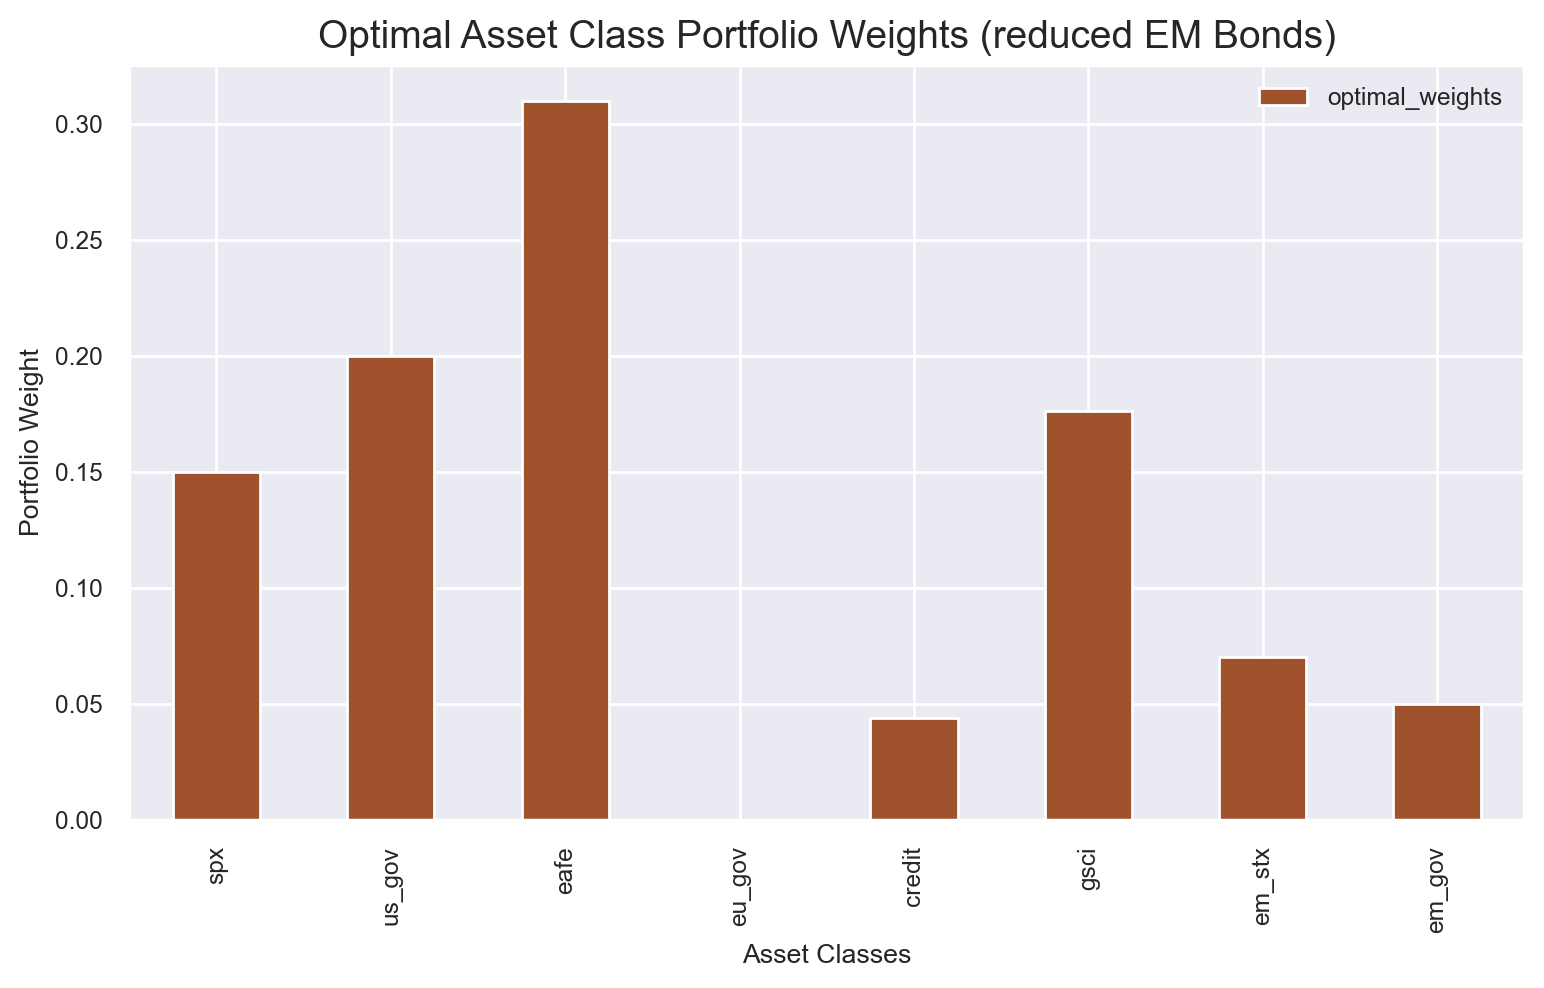

In [34]:
ax = opt_xem.plot(kind='bar', color='sienna', figsize=(9, 5))
ax.set_xlabel("Asset Classes")
ax.set_ylabel("Portfolio Weight")
ax.set_title("Optimal Asset Class Portfolio Weights (reduced EM Bonds)", fontsize=14)
plt.show()

# Simulated Portfolio Returns

Simulate 300 rows of returns for each of the asset classes. Each row of returns is simulated assuming a multivariate normal distribution based on each asset's expected returns (mean), expected variance, and the 2013-2020 covariance data.

Each row of asset returns are then used to construct a portfolio return corresponding to the allocated weights found earlier, one for the original portfolio and another for the EM-limited portfolio. We end up with 300 weighted returns for each portfolio.

We purposely set the number of simulations at a **moderate 300**. These simulated returns in the end are not observations of the "true" returns, but are simulations based on the capital market assumptions we have been using. We do not want the illusion of having a large number of "true" data, when we really don't. A large number of empirical data will influence the Bayesian posterior distribution decisively, and we don't want that. On the other hand, we should have some confidence in our capital market assumptions. There is no firm rule, but we choose 300 as a compromise.

In [35]:
# Number of simulated observations (or rows)
num_sim = 300

In [36]:
X = np.random.multivariate_normal(expected_returns.ravel(), ecov_all, size=num_sim)

C:\Users\camb7\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: covariance is not positive-semidefinite.
  """Entry point for launching an IPython kernel.


In [37]:
X = pd.DataFrame(X, columns=df_port.columns)

In [38]:
X.head()

spx    us_gov      eafe    eu_gov    credit      gsci    em_stx  \
0  0.051395  0.007295  0.085446 -0.003905  0.004385  0.032061  0.062702   
1  0.063934  0.007951  0.074969 -0.006435 -0.001398  0.014965  0.055815   
2  0.075196  0.006132  0.085393  0.003785  0.011367  0.031663  0.079141   
3  0.068729  0.007904  0.089695  0.000864  0.006031  0.031815  0.079219   
4  0.046899  0.007803  0.069187 -0.005127  0.001172  0.017349  0.047011   

     em_gov    ch_gov  
0  0.032867  0.029591  
1  0.029425  0.033558  
2  0.040737  0.030350  
3  0.038707  0.031559  
4  0.029495  0.028216

Recall the various assets' expected returns and volatilities above, and they match approximately with the respective means and variances of the simulated portfolios, as one would expect.

In [39]:
X_xem = np.random.multivariate_normal(expected_returns_xem.ravel(), ecov_xem, size=num_sim)

C:\Users\camb7\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: covariance is not positive-semidefinite.
  """Entry point for launching an IPython kernel.


In [40]:
X_xem = pd.DataFrame(X_xem, columns=df_port_xem.columns)

In [41]:
X_xem.head()

spx    us_gov      eafe    eu_gov    credit      gsci    em_stx  \
0  0.053476  0.006880  0.072925 -0.003158  0.001714  0.021775  0.076513   
1  0.057707  0.008861  0.069058 -0.004760  0.003217  0.018698  0.067123   
2  0.051905  0.006716  0.065095 -0.004316  0.003112  0.005111  0.056235   
3  0.063758  0.011199  0.083565  0.002558  0.008372  0.035283  0.086681   
4  0.056957  0.000768  0.086738 -0.007199 -0.002167  0.019016  0.085643   

     em_gov  
0  0.031544  
1  0.030829  
2  0.029359  
3  0.038893  
4  0.034467

In [42]:
X.describe()

spx      us_gov        eafe      eu_gov      credit        gsci  \
count  300.000000  300.000000  300.000000  300.000000  300.000000  300.000000   
mean     0.063195    0.007171    0.074779   -0.003884    0.002592    0.022701   
std      0.010444    0.003498    0.009789    0.003583    0.003520    0.009828   
min      0.031992   -0.000957    0.042838   -0.018164   -0.008861   -0.008548   
25%      0.055899    0.004652    0.068389   -0.006207    0.000176    0.015908   
50%      0.064628    0.007243    0.074768   -0.003900    0.002622    0.022857   
75%      0.070213    0.009738    0.081973   -0.001541    0.005189    0.029717   
max      0.095773    0.016691    0.100727    0.006913    0.011472    0.049407   

           em_stx      em_gov      ch_gov  
count  300.000000  300.000000  300.000000  
mean     0.070846    0.034114    0.030768  
std      0.012426    0.005084    0.002677  
min      0.035513    0.015740    0.023962  
25%      0.062999    0.031004    0.029028  
50%      0.071437    0.034132    0.030847  
75%      0.079119    0.037479    0.032335  
max      0.105100    0.046483    0.038196

In [43]:
X_xem.describe()

spx      us_gov        eafe      eu_gov      credit        gsci  \
count  300.000000  300.000000  300.000000  300.000000  300.000000  300.000000   
mean     0.062808    0.007071    0.074670   -0.004143    0.002159    0.023327   
std      0.010856    0.003495    0.009439    0.003528    0.003585    0.009755   
min      0.030976   -0.003519    0.050715   -0.013854   -0.010662   -0.007370   
25%      0.055888    0.004580    0.068259   -0.006543   -0.000269    0.016665   
50%      0.062738    0.007012    0.075261   -0.004318    0.001935    0.023782   
75%      0.069443    0.009430    0.081220   -0.001562    0.004810    0.029932   
max      0.092445    0.017301    0.100136    0.005242    0.011681    0.049432   

           em_stx      em_gov  
count  300.000000  300.000000  
mean     0.071048    0.033867  
std      0.013512    0.005214  
min      0.029722    0.018402  
25%      0.062495    0.030165  
50%      0.071431    0.033985  
75%      0.079934    0.037683  
max      0.106220    0.047951

### Generate distributions of simulated portfolio data

In [44]:
# Recall the first optimized portfolio weights
opt

optimal_weights
spx        1.500000e-01
us_gov     2.000000e-01
eafe       3.100000e-01
eu_gov     2.969847e-15
credit     9.024390e-02
gsci       2.975610e-02
em_stx     7.000000e-02
em_gov     1.000000e-01
ch_gov     5.000000e-02

In [45]:
opt_xem

optimal_weights
spx            0.150000
us_gov         0.200000
eafe           0.310000
eu_gov         0.000000
credit         0.043902
gsci           0.176098
em_stx         0.070000
em_gov         0.050000

In [46]:
port_sim = np.dot(X, opt).ravel()
port_xem_sim = np.dot(X_xem, opt_xem).ravel()

In [47]:
# Confirm that resulting portfolio returns array has the correct number of rows
len(port_sim)

300

In [48]:
len(port_xem_sim)

300

In [49]:
# Check that the mean portfolio return is indeed 4.1%, the "target return"
print("Simulated portfolio mean return: {:0.6f}".format(port_sim.mean()))
print("Simulated portfolio ex-EM bonds mean return: {:0.6f}".format(port_xem_sim.mean()))

Simulated portfolio mean return: 0.044913
Simulated portfolio ex-EM bonds mean return: 0.044853


In [50]:
# Check that the portfolio volatilities
print("Simulated portfolio annualized std: {:0.6f}".format(np.var(port_sim, ddof=1)**0.5*(253**0.5)))
print("Simulated portfolio ex-EM bonds annualized std: {:0.6f}".format(np.var(port_xem_sim, ddof=1)**0.5*(253**0.5)))

Simulated portfolio annualized std: 0.078721
Simulated portfolio ex-EM bonds annualized std: 0.086751


In [51]:
print("Simulated portfolio kurtosis: {:0.6f}".format(kurtosis(port_sim, fisher=False)))
print("Simulated portfolio ex-EM bonds kurtosis: {:0.6f}".format(kurtosis(port_xem_sim, fisher=False)))

Simulated portfolio kurtosis: 2.926965
Simulated portfolio ex-EM bonds kurtosis: 2.802973


In [52]:
# Portfolio standard deviations (non-annualised)
print("Simulated portfolio std: {:0.6f}".format(np.var(port_sim, ddof=1)**0.5))
print("Simulated portfolio ex-EM bonds std: {:0.6f}".format(np.var(port_xem_sim, ddof=1)**0.5))

Simulated portfolio std: 0.004949
Simulated portfolio ex-EM bonds std: 0.005454


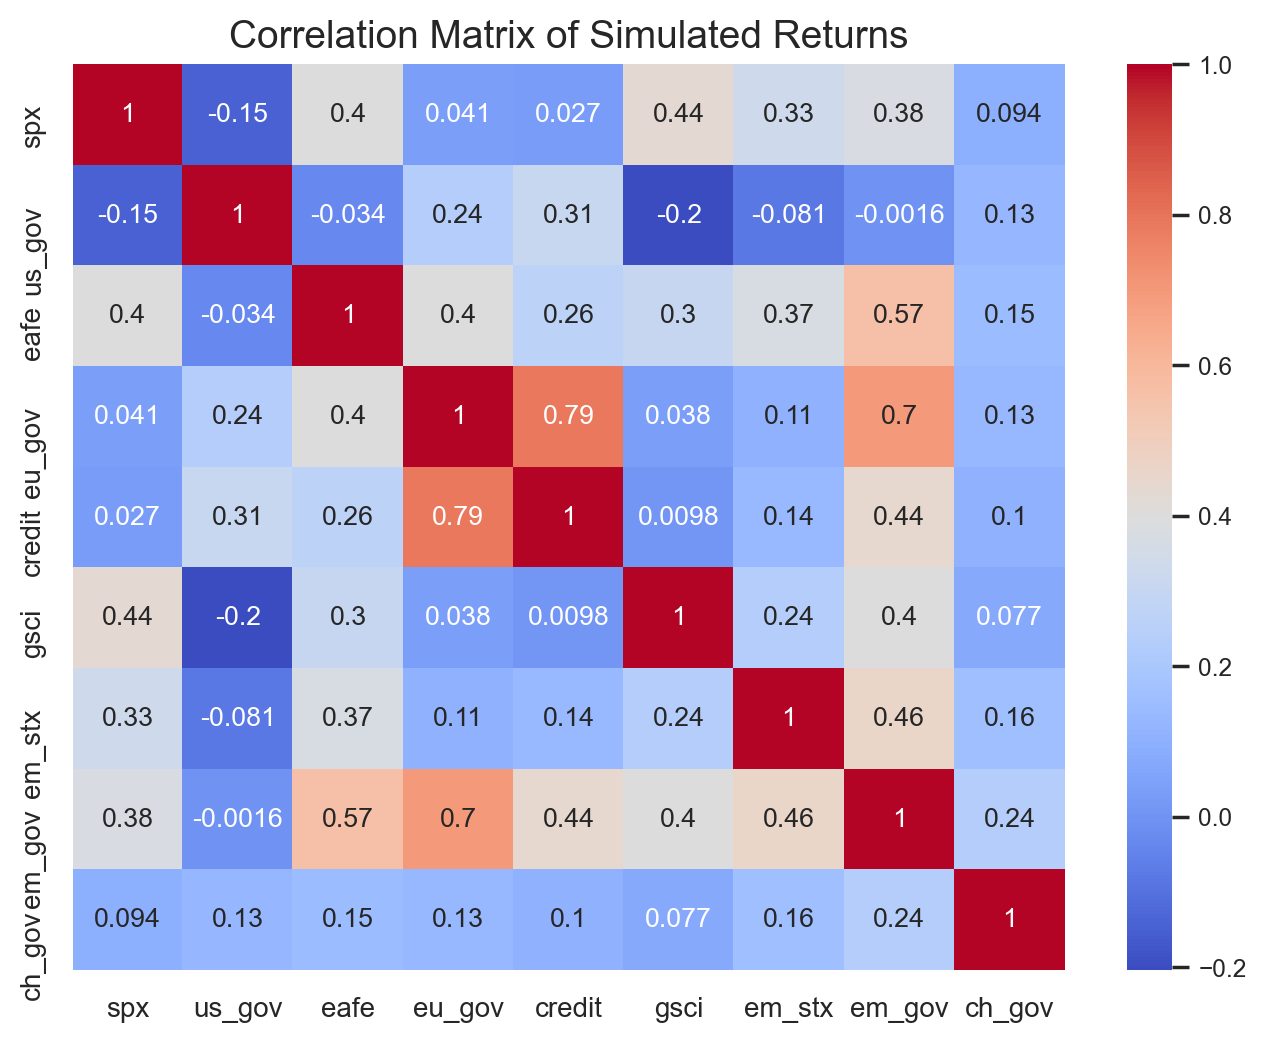

In [53]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.set(font_scale=0.8)
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', ax=ax)
ax.set_title("Correlation Matrix of Simulated Returns", fontsize=14)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=10)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=10)
plt.show()

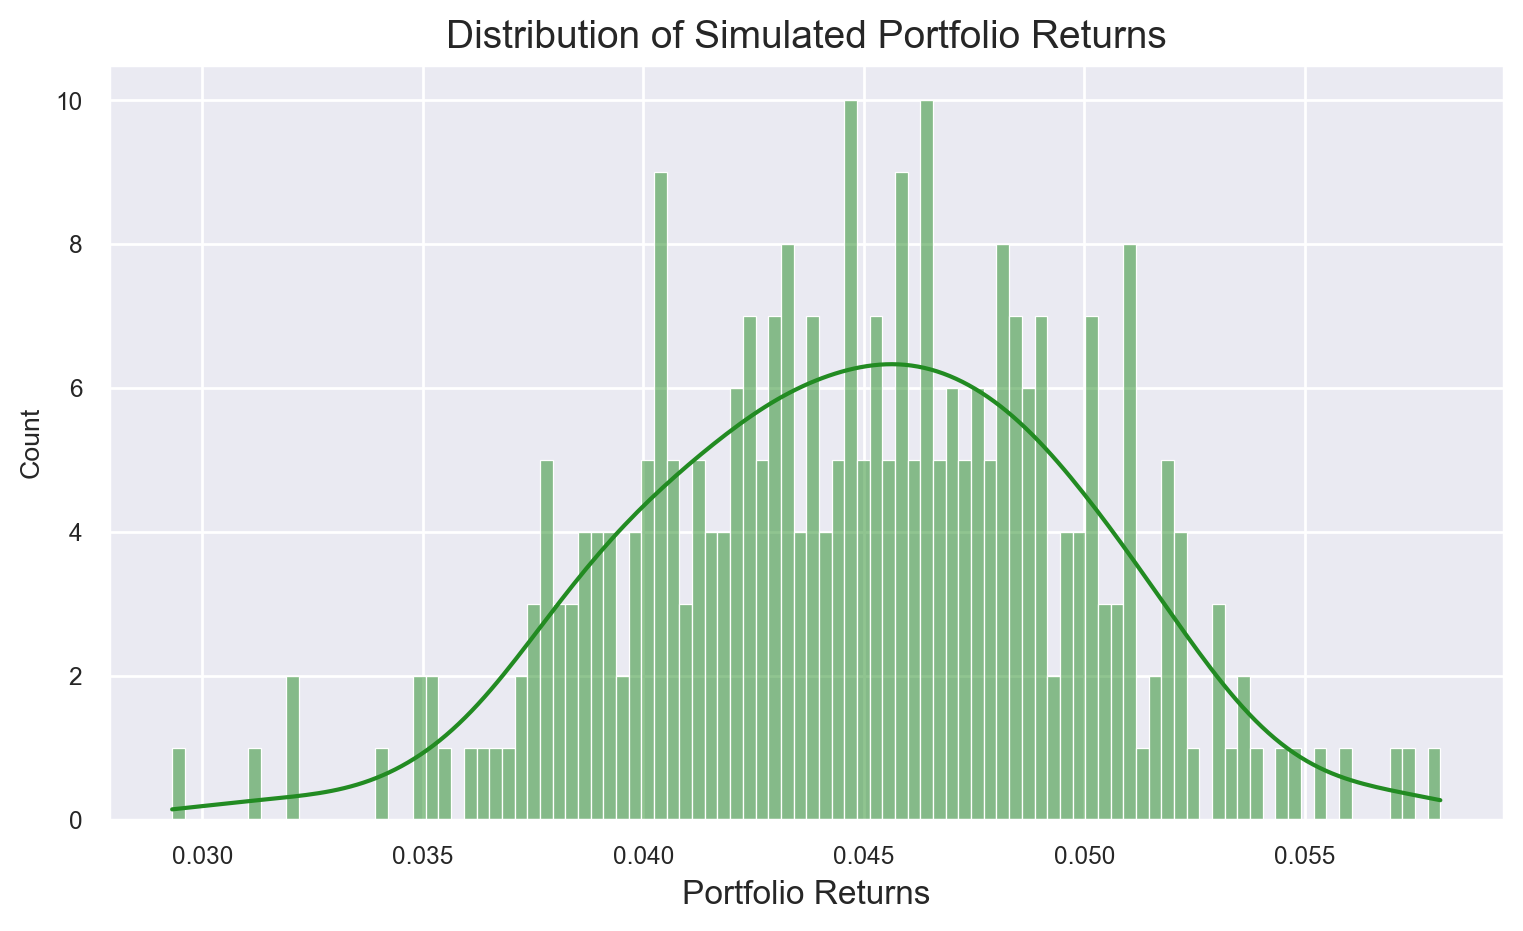

In [54]:
fig, ax = plt.subplots(figsize=(9,5))

sns.histplot(port_sim, bins=100, kde=True, ax=ax, color='forestgreen')
plt.title('Distribution of Simulated Portfolio Returns', fontsize=14)
plt.xlabel('Portfolio Returns', fontsize=12);

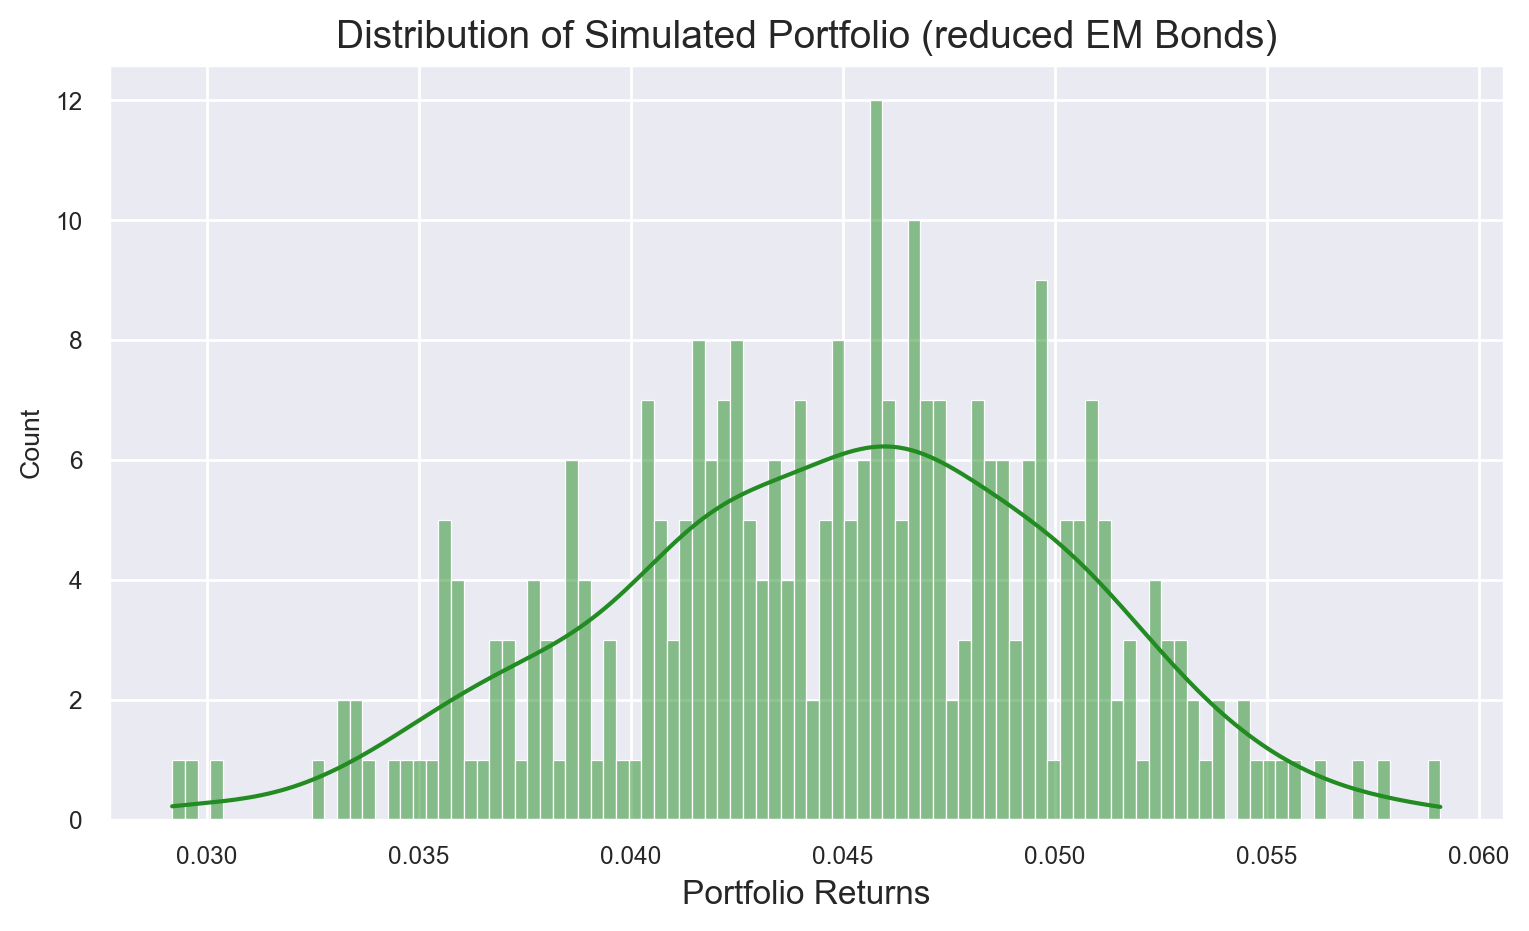

In [55]:
fig, ax = plt.subplots(figsize=(9,5))

sns.histplot(port_xem_sim, bins=100, kde=True, ax=ax, color='forestgreen')
plt.title('Distribution of Simulated Portfolio (reduced EM Bonds)', fontsize=14)
plt.xlabel('Portfolio Returns', fontsize=12);

# Bayesian Modeling

In [56]:
df_empiric = pd.DataFrame(
    dict(returns=np.r_[port_sim, port_xem_sim], 
         group=np.r_[["all"] * len(port_sim), ["xem"] * len(port_xem_sim)])
)

In [57]:
df_empiric

returns group
0    0.046162   all
1    0.043267   all
2    0.052077   all
3    0.052180   all
4    0.038316   all
..        ...   ...
595  0.037765   xem
596  0.041903   xem
597  0.039048   xem
598  0.043914   xem
599  0.050852   xem

[600 rows x 2 columns]

In [58]:
# Set the simulated portfolio data as the empirical values
y1 = np.array(port_sim)
y2 = np.array(port_xem_sim)

The Bayesian modelling below starts with the three prior distributions:
+ of the portfolio means;
+ of the portfolio standard deviations; and
+ of the degrees of freedom of the likelihood function.

The **prior distributions of the portfolio means** are assumed to follow **normal distributions** with mean and standard deviations (multiplied by 2 to increase the dispersion of the distribution arbitrarily) of the pooled sample of simulated portfolio data (above).

In the initial case, **uniform distributions** with a lower bound of 0 and a upper bound of 0.15 are used as a *weak* prior distribution for **the portfolio (non-annualized) standard deviations**.

The two prior distributions of the standard deviations are:
+ *sigma_all* for the standard deviation of the expected returns of the portfolio with all nine asset classes; and
+ *sigma_xem* for the standard deviation of the expected returns of the EM-limited portfolio

The **likelihood function of the portfolio data** are assumed to be Student's t-distributions, so **fat-tailed symmetrical distributions**. The respective likelihood distributions, which are the sampling distributions of the algorithm, incorporate the prior mean and prior standard deviation.

There is also a **prior distribution of the degrees of freedom** for the t-distributions above, assuming the **same df** for both likelihood functions.

**Deterministic random variables** comprised of the difference between the means and standard deviations are finally added to the model. These are deterministic variables in that their values are derived completely from their parent's values, first of the means and then the standard deviations.

### First Bayesian model

In [59]:
μ_m = df_empiric.returns.mean()
μ_s = df_empiric.returns.std()*2 # Multiply the observed pooled standard deviation by 2 for greater dispersion

with pm.Model() as model1:

    # Prior distributions for portfolio means
    mu_all = pm.Normal('mu_all', mu=μ_m, sd=μ_s)
    mu_xem = pm.Normal('mu_xem', mu=μ_m, sd=μ_s)
    
    # Prior distributions for portfolio standard deviations
    sigma_all = pm.Uniform("sigma_all", lower=0, upper=0.15) #Very wide with zero left bound...
    sigma_xem = pm.Uniform("sigma_xem", lower=0, upper=0.15) # and 0.15 as the right bound
    
    # Prior distribution for degrees of freedom
    nu = pm.Gamma('nu', alpha=2, beta=0.1)
    
    # Likelihood functions for portfolio data
    all_est = pm.StudentT('all_est', nu=nu, mu=mu_all, sd=sigma_all, observed=y1)
    xem_est = pm.StudentT('xem_est', nu=nu, mu=mu_xem, sd=sigma_xem, observed=y2)
    

In [60]:
with model1:
    means_diff = pm.Deterministic("difference of means", mu_all - mu_xem)
    std_diff = pm.Deterministic("difference of stds", sigma_all - sigma_xem)
    ann_std_diff = pm.Deterministic("difference annualized stds", (sigma_all - sigma_xem)*(253**0.5))

In [61]:
with model1:
    trace1 = pm.sample(5000, tune=2000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma_xem, sigma_all, mu_xem, mu_all]
Sampling 4 chains, 0 divergences: 100%|█████████████████████████████████████| 28000/28000 [00:19<00:00, 1471.70draws/s]


C:\Users\camb7\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\camb7\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\camb7\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\camb7\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend

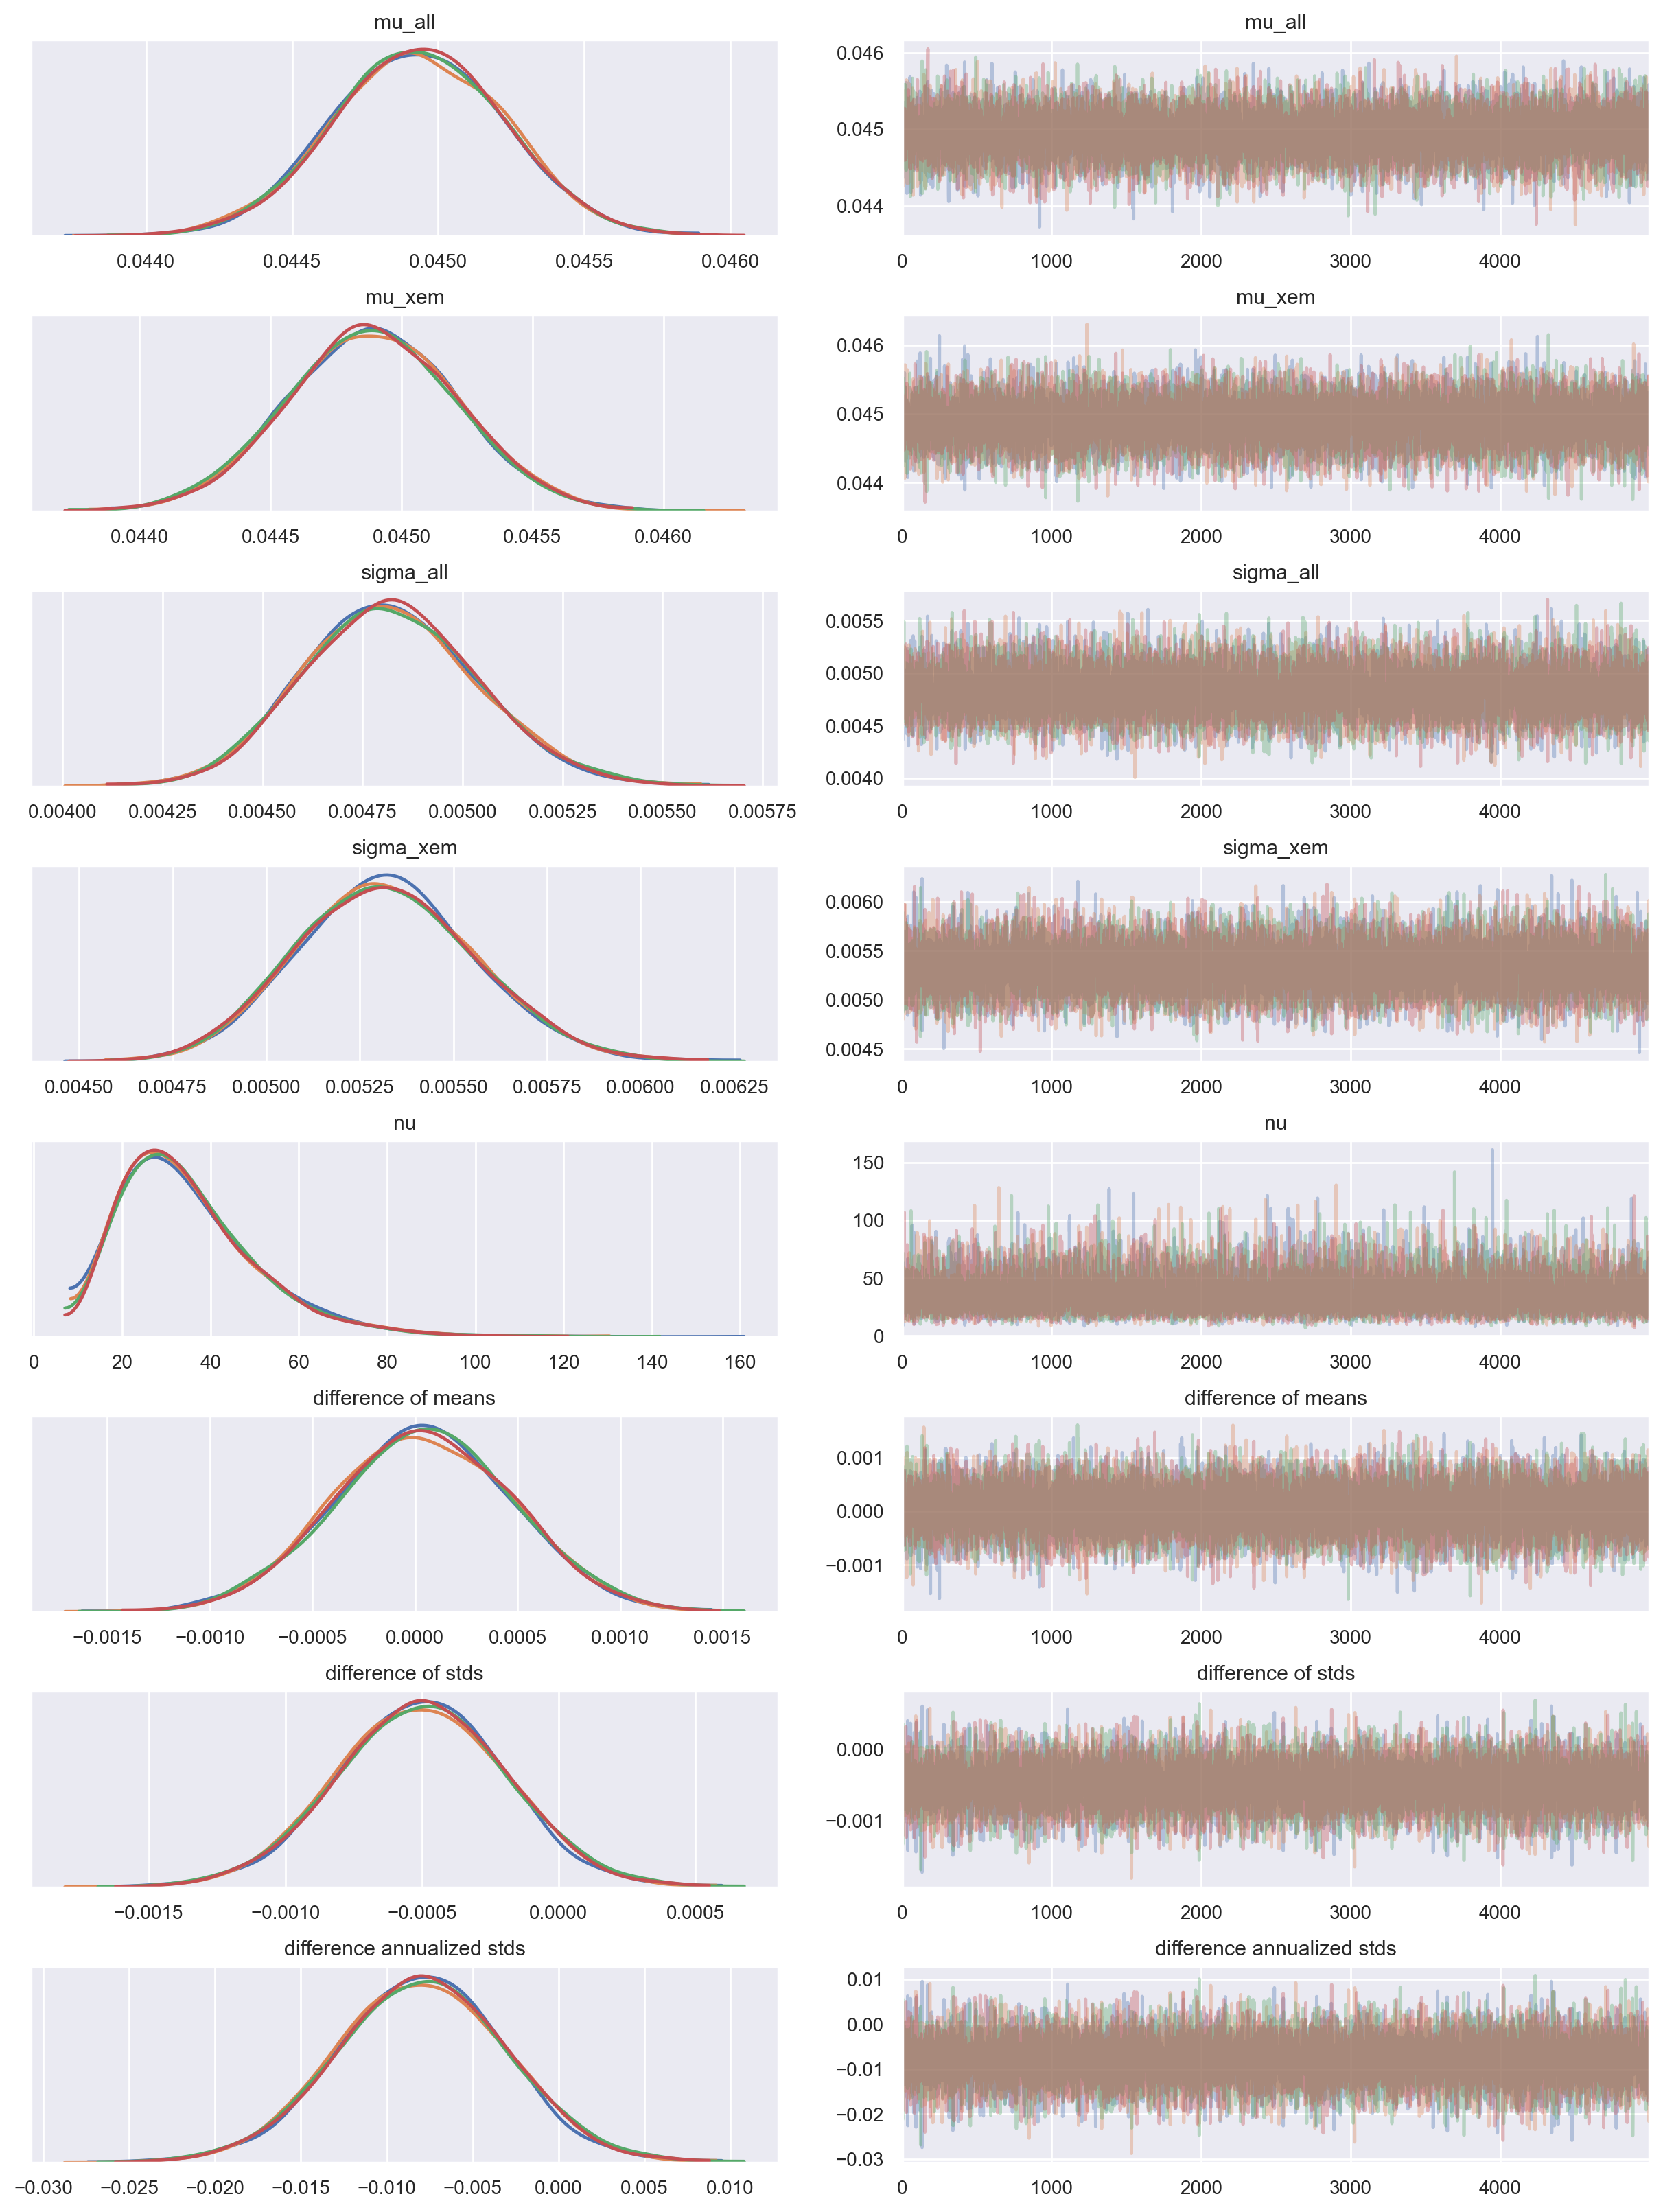

In [62]:
with model1:
    az.plot_trace(trace1, compact = True);

In [63]:
sns.set(font_scale=1.0)

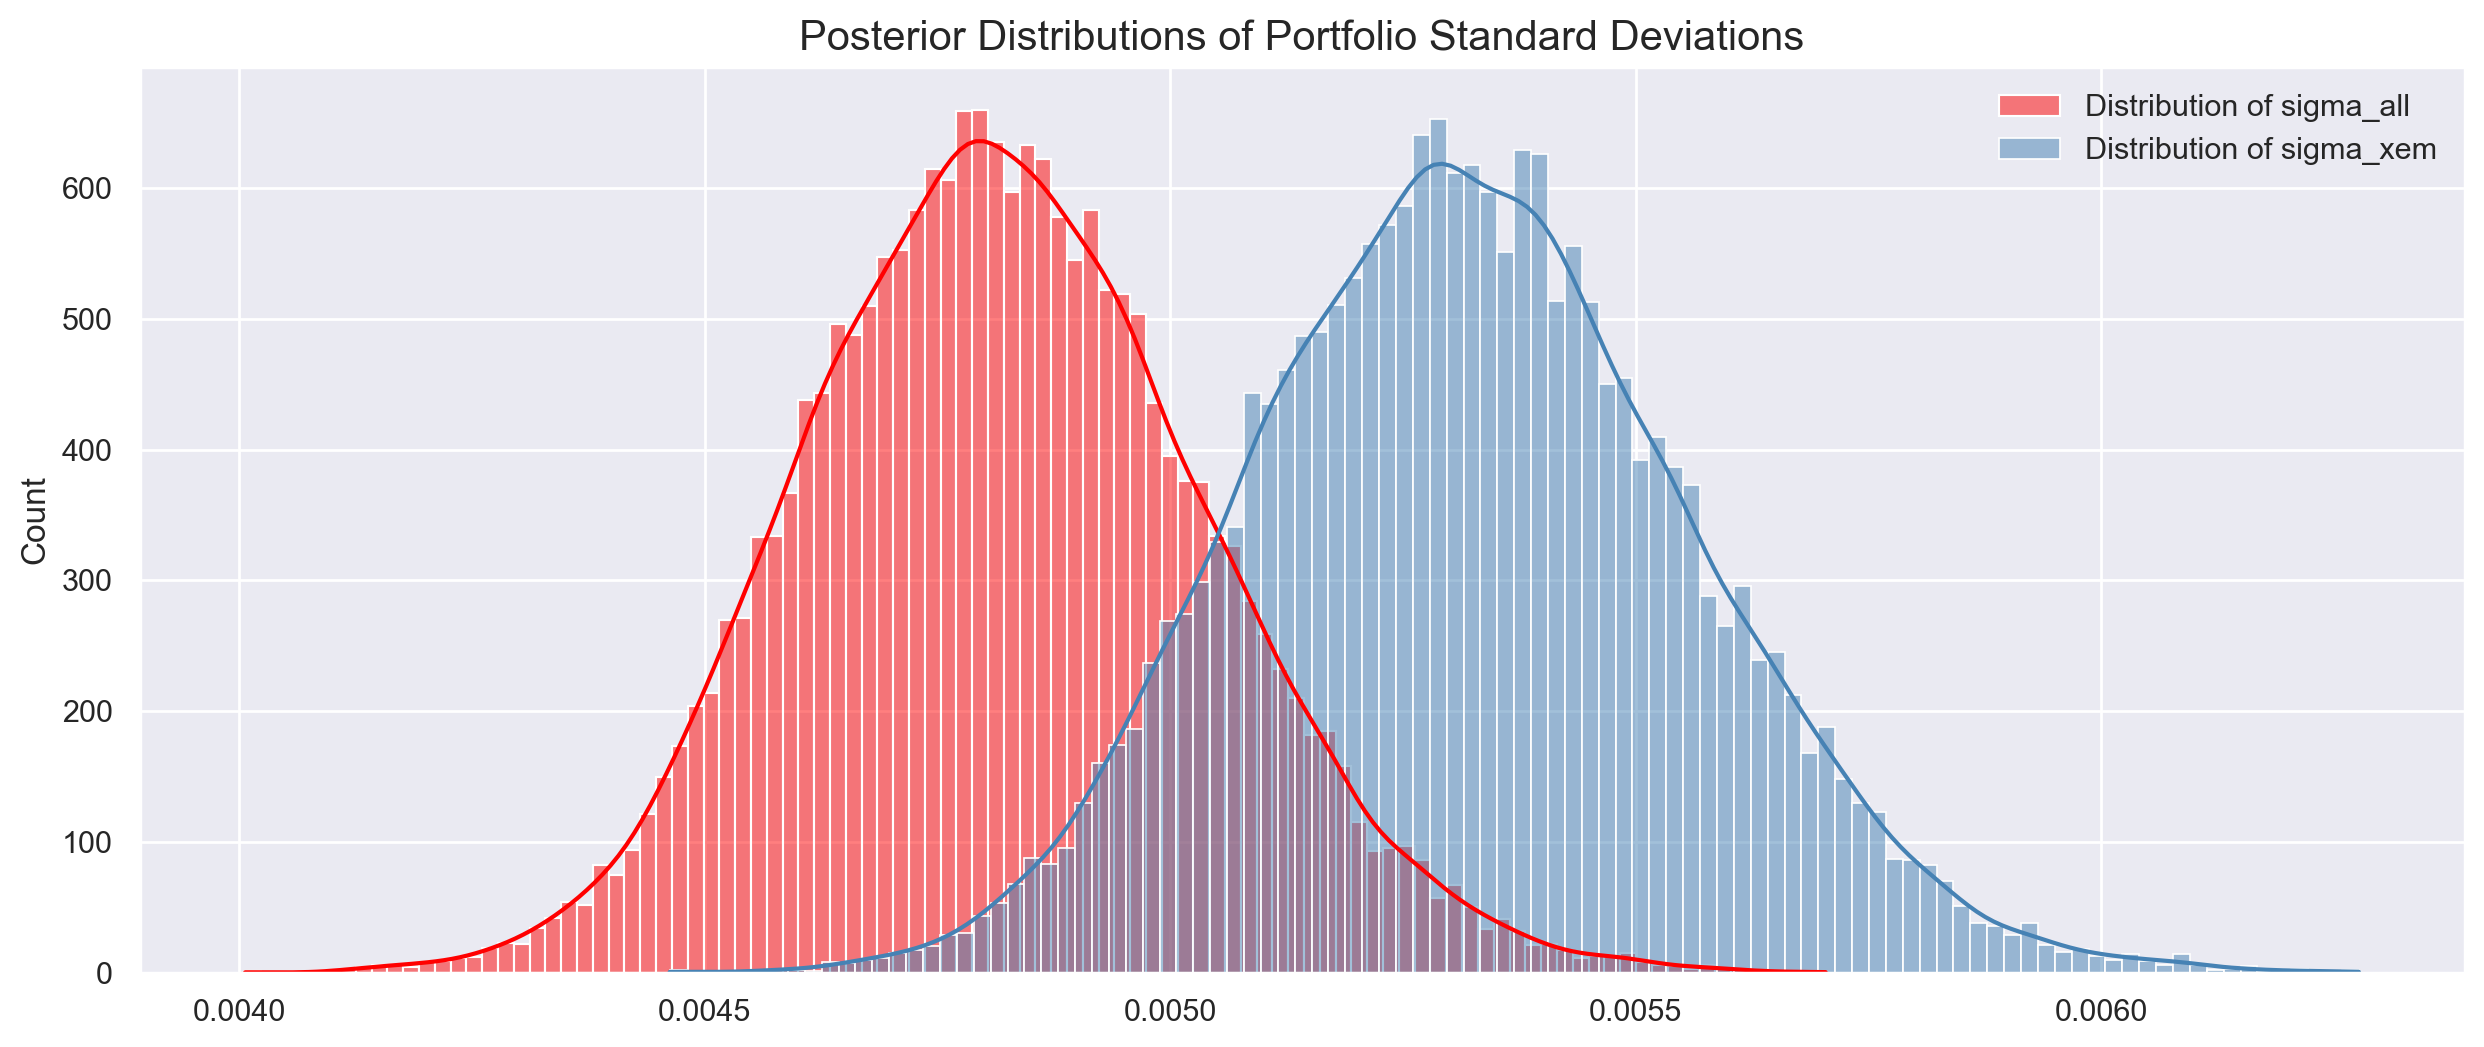

In [64]:
fig, ax = plt.subplots(figsize=(15,6))

sns.histplot(trace1['sigma_all'], bins=100, kde=True, ax=ax, color='red', label='Distribution of sigma_all')
sns.histplot(trace1['sigma_xem'], bins=100, kde=True, ax=ax, color='steelblue', label='Distribution of sigma_xem')
plt.title('Posterior Distributions of Portfolio Standard Deviations', fontsize=15)
plt.legend();

In [65]:
print("Mean estimate of the original portfolio stdev is: {:0.6f}".format(trace1['sigma_all'].mean()))
print("Mean estimate of the EM-limited portfolio stdev is: {:0.6f}".format(trace1['sigma_xem'].mean()))

Mean estimate of the original portfolio stdev is: 0.004822
Mean estimate of the EM-limited portfolio stdev is: 0.005323


In [66]:
# The point estimates of the annualized standard deviations
print("Mean estimate of the original portfolio volatility is: {:0.6f}".format(trace1['sigma_all'].mean()*(253**0.5)))
print("Mean estimate of the EM-limited portfolio volatility is: {:0.6f}".format(trace1['sigma_xem'].mean()*(253**0.5)))

Mean estimate of the original portfolio volatility is: 0.076699
Mean estimate of the EM-limited portfolio volatility is: 0.084664


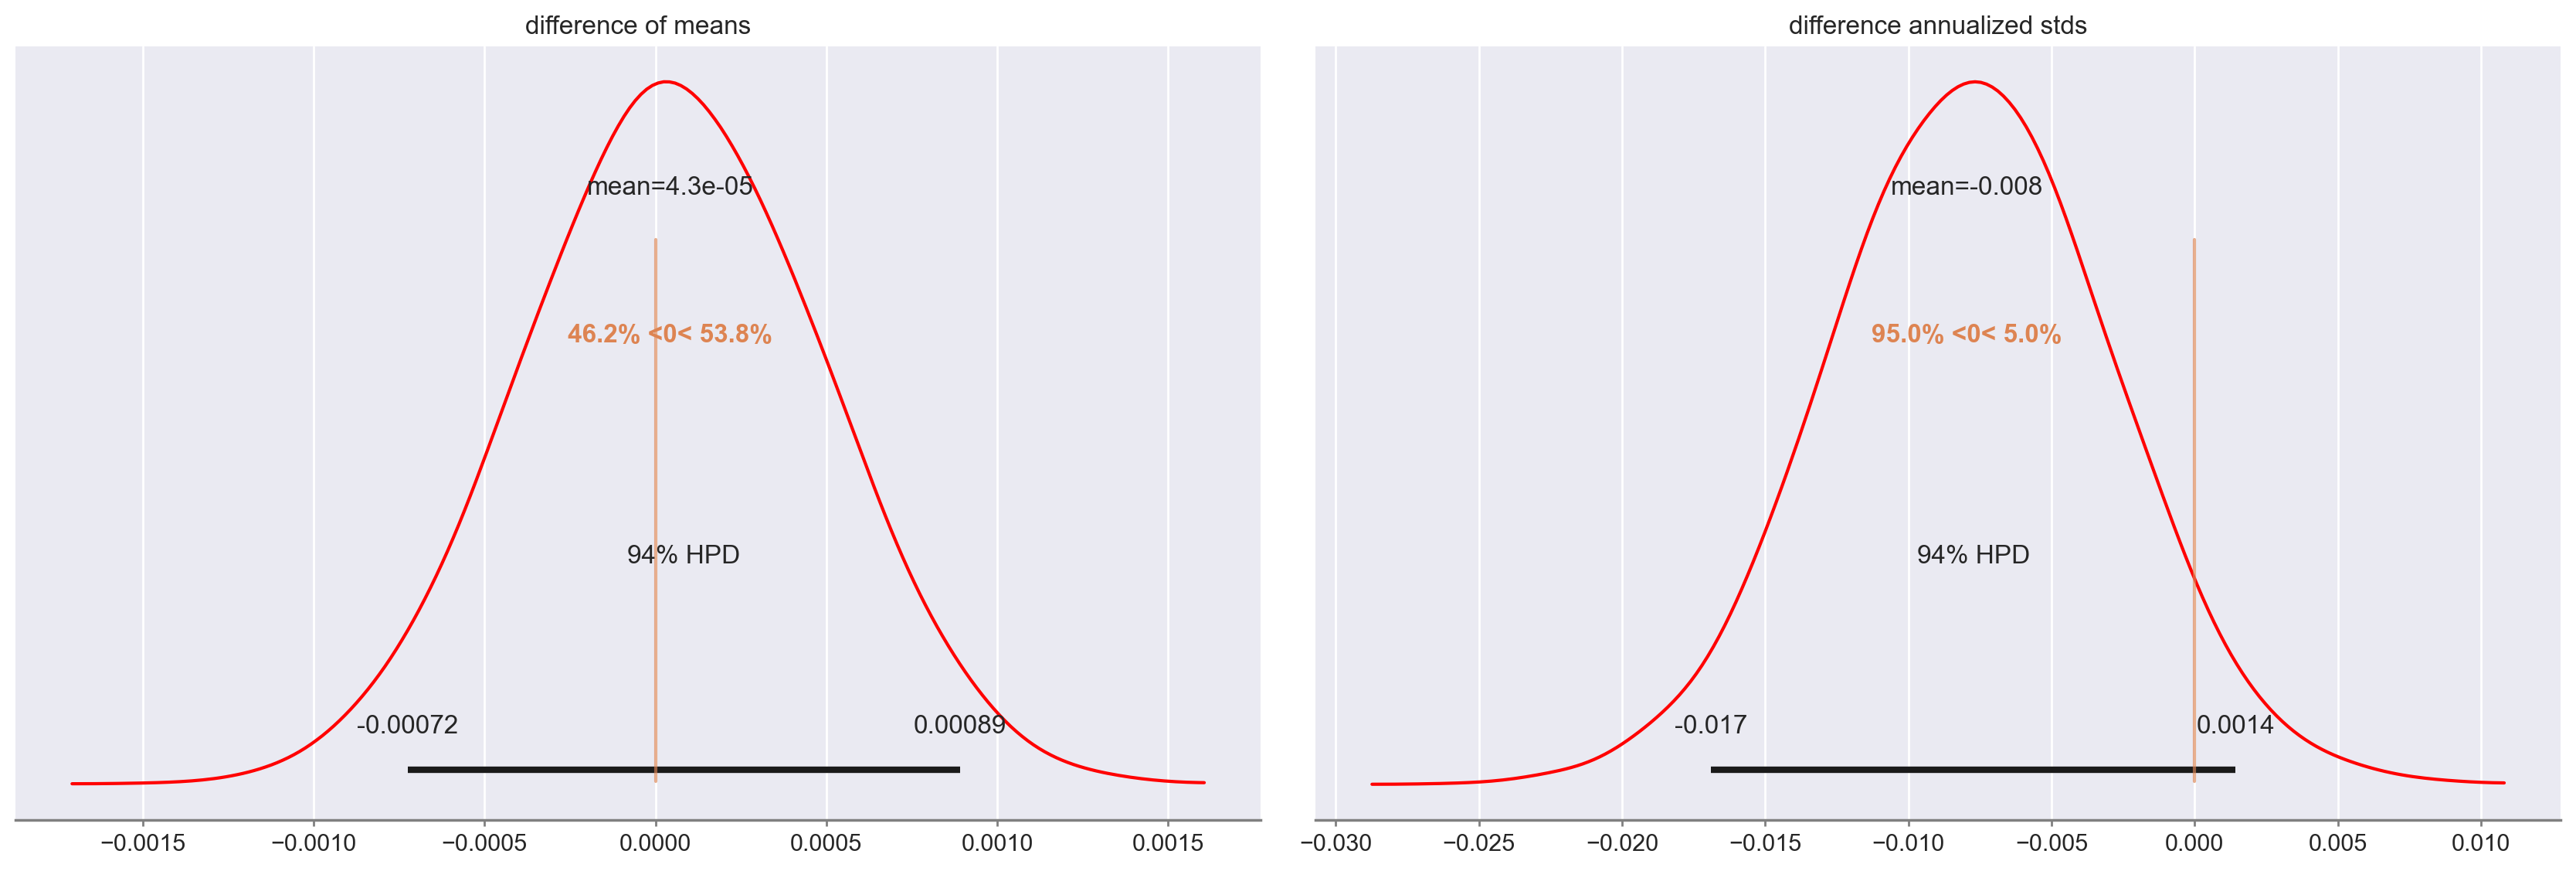

In [67]:
pm.plot_posterior(
    trace1,
    var_names=["difference of means", "difference annualized stds"],
    ref_val=0,
    color="red",
);

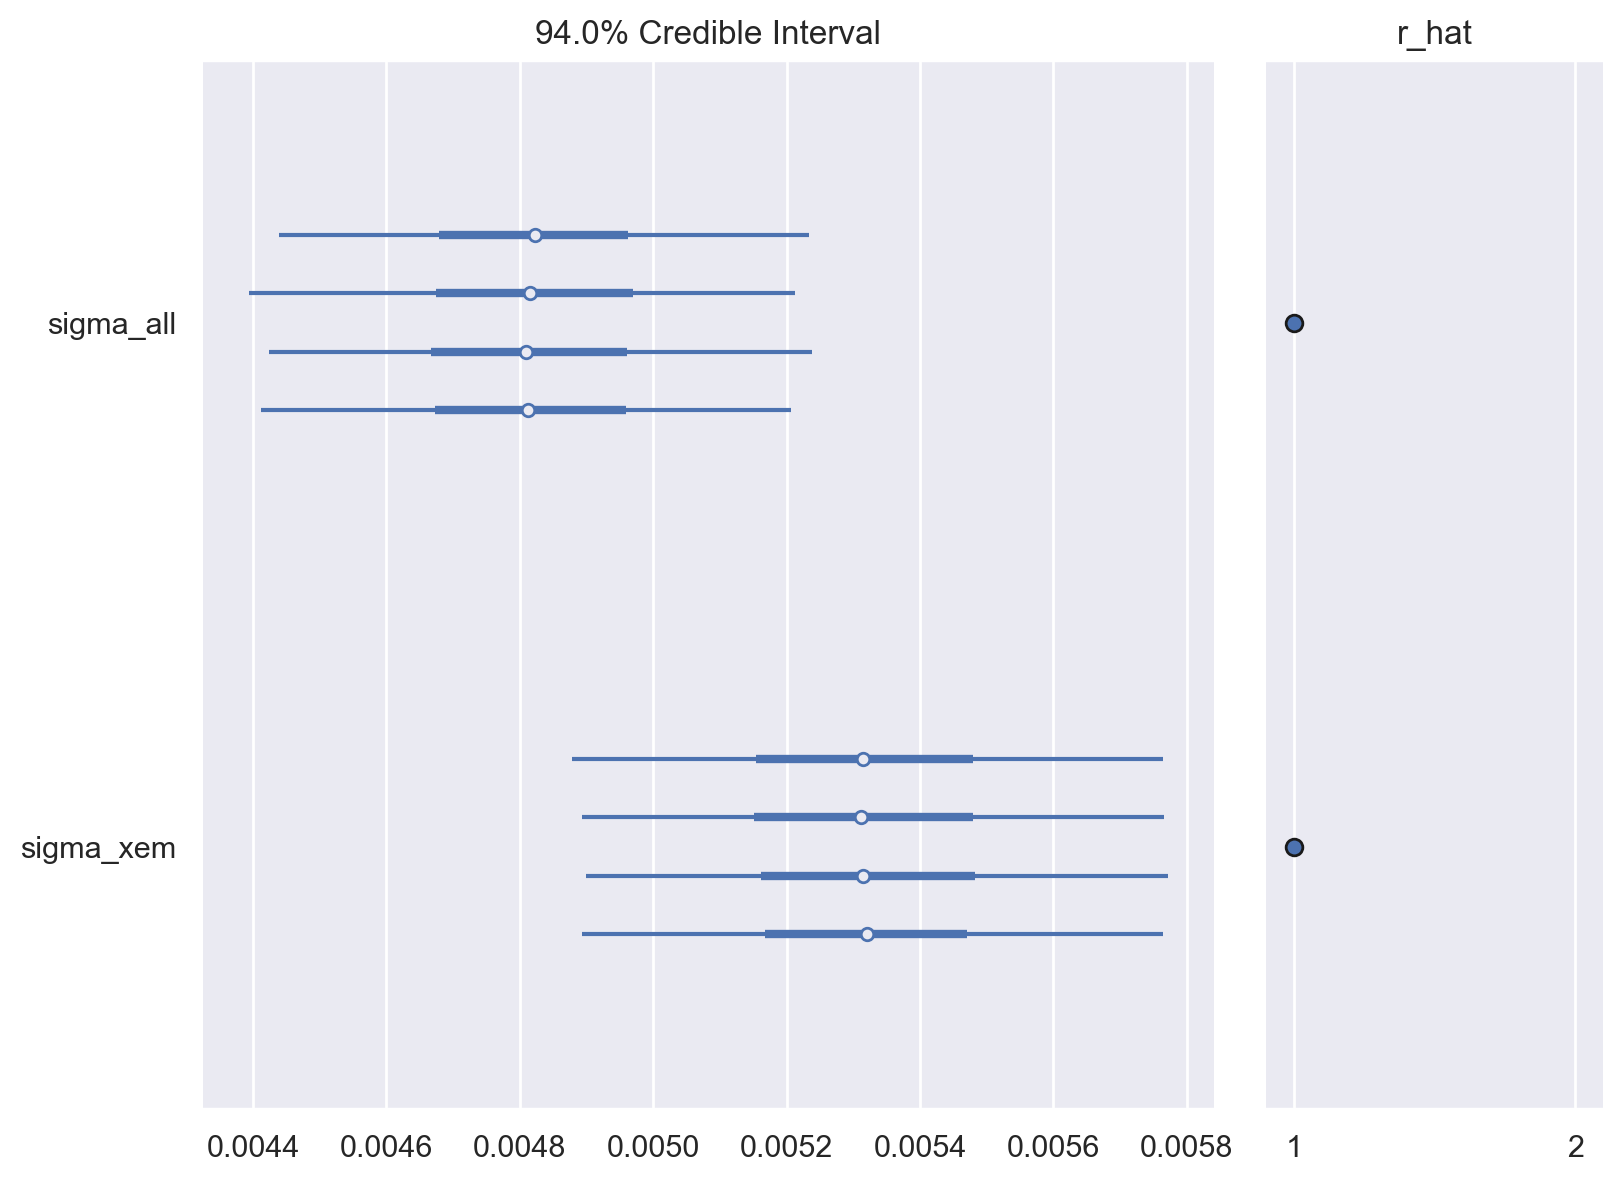

In [68]:
az.plot_forest(trace1, var_names=["sigma_all", "sigma_xem"], r_hat=True);

In [69]:
pm.summary(trace1, varnames=["difference of means", "difference of stds", "difference annualized stds"])

C:\Users\camb7\anaconda3\lib\site-packages\pymc3\stats\__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.9
  "pymc3 3.9".format(old=old, new=new)


mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  \
difference of means         0.000  0.000  -0.001    0.001        0.0      0.0   
difference of stds         -0.001  0.000  -0.001    0.000        0.0      0.0   
difference annualized stds -0.008  0.005  -0.017    0.001        0.0      0.0   

                            ess_mean   ess_sd  ess_bulk  ess_tail  r_hat  
difference of means          29867.0  10180.0   29844.0   15154.0    1.0  
difference of stds           30976.0  23761.0   31005.0   16432.0    1.0  
difference annualized stds   30976.0  23761.0   31005.0   16432.0    1.0

### Second Bayesian model

In this second Bayesian model, the **weak Uniform prior distribution** of the standard deviations is replaced by the more *informative prior* of the **half-Cauchy distribution**. The standard deviation is a *positive* continuous distribution, and the half-Cauchy is equivalent with the (positive right-side) of the half-t-distribution with 1 or 2 degrees of freedom. In other words, the half-Cauchy is the positive half of a fat-tailed symmetrical distribution. This is expected to be more representative of the distribution of standard deviations, and is therefore a more *informative prior*. Still, a high beta of 10 is assigned to the half-Cauchy to reduce its influence on the posterior.

In [70]:
μ_m = df_empiric.returns.mean()
μ_s = df_empiric.returns.std()*2

with pm.Model() as model2:

    # Prior distributions for portfolio means
    mu_all = pm.Normal('mu_all', mu=μ_m, sd=μ_s)
    mu_xem = pm.Normal('mu_xem', mu=μ_m, sd=μ_s)
    
    # Prior distributions for portfolio standard deviations
    sigma_all = pm.HalfCauchy('sigma_all', beta=10) # beta=10 allows for a wide positive distribution
    sigma_xem = pm.HalfCauchy('sigma_xem', beta=10)

    # Prior distribution for the degrees of freedom  
    nu = pm.Gamma('nu', alpha=2, beta=0.1)
    
    # Likelihood functions for portfolio data
    all_est = pm.StudentT('all_est', nu=nu, mu=mu_all, sd=sigma_all, observed=y1)
    xem_est = pm.StudentT('xem_est', nu=nu, mu=mu_xem, sd=sigma_xem, observed=y2)
    

In [71]:
with model2:
    means_diff = pm.Deterministic("difference of means", mu_all - mu_xem)
    std_diff = pm.Deterministic("difference of stds", sigma_all - sigma_xem)
    ann_std_diff = pm.Deterministic("difference annualized stds", (sigma_all - sigma_xem)*(253**0.5))

In [72]:
with model2:
    trace2 = pm.sample(5000, tune=2000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma_xem, sigma_all, mu_xem, mu_all]
Sampling 4 chains, 0 divergences: 100%|█████████████████████████████████████| 28000/28000 [00:19<00:00, 1429.88draws/s]


C:\Users\camb7\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\camb7\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\camb7\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\camb7\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend

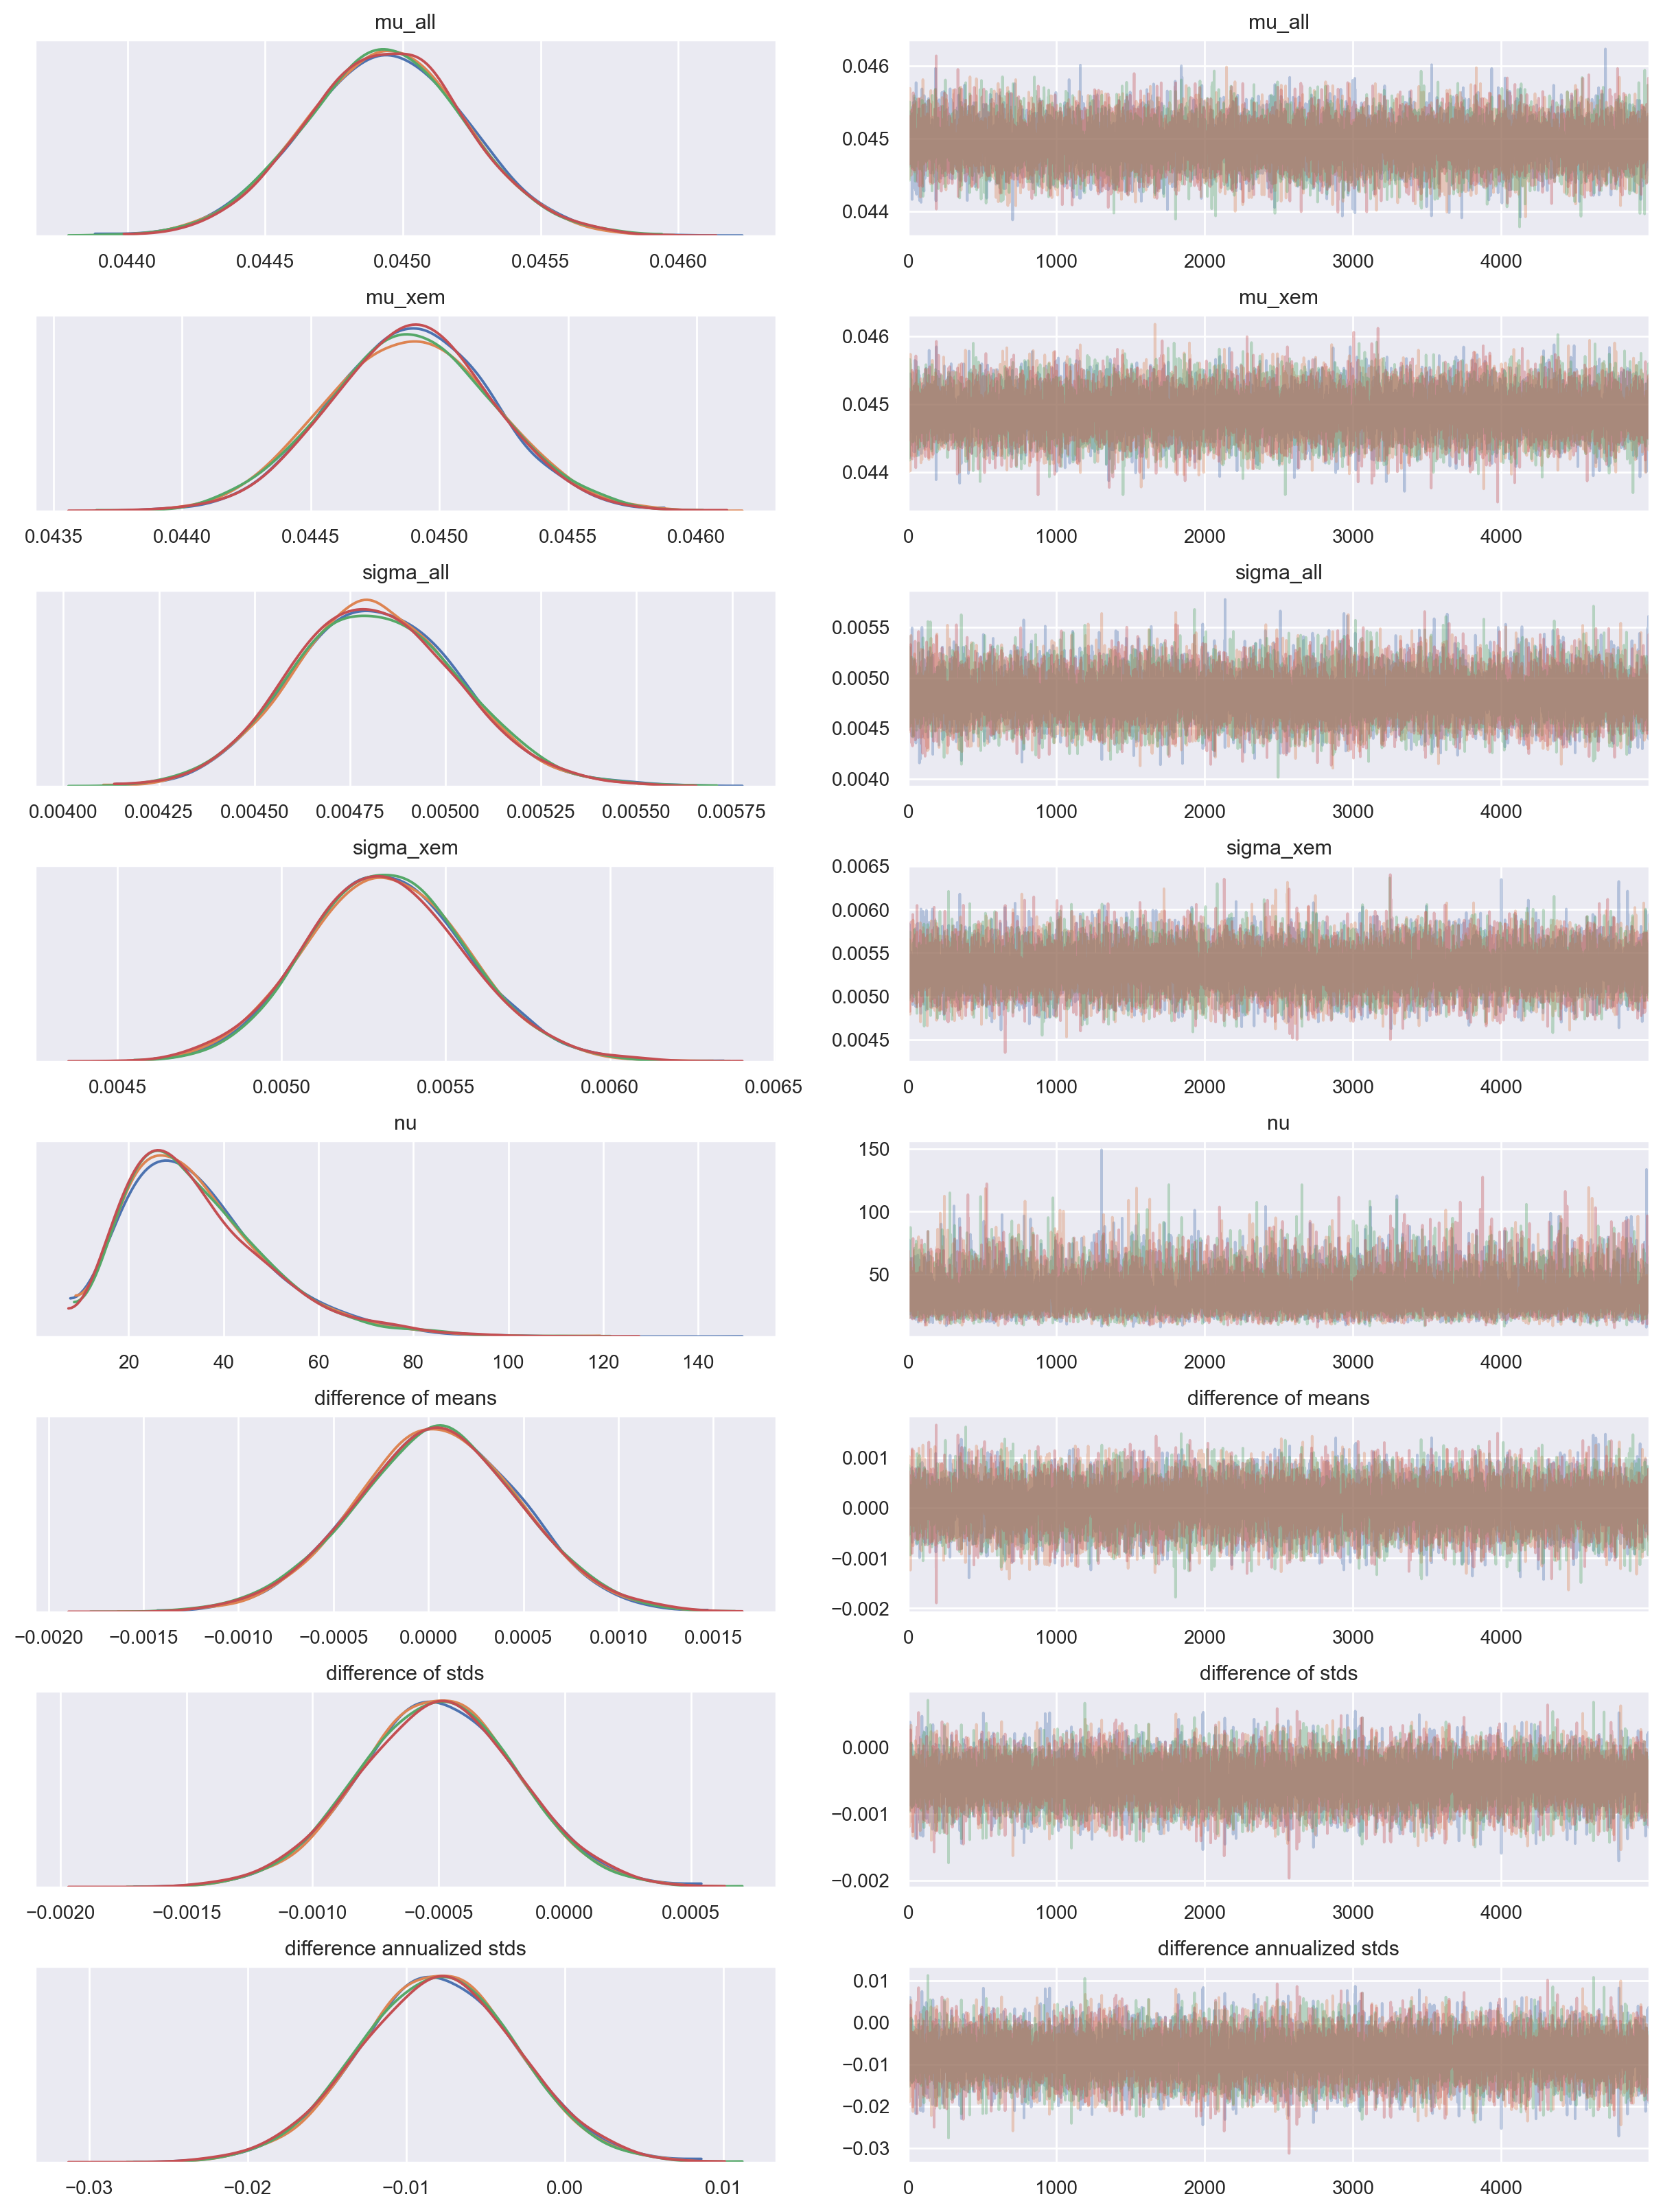

In [73]:
with model2:
    az.plot_trace(trace2);

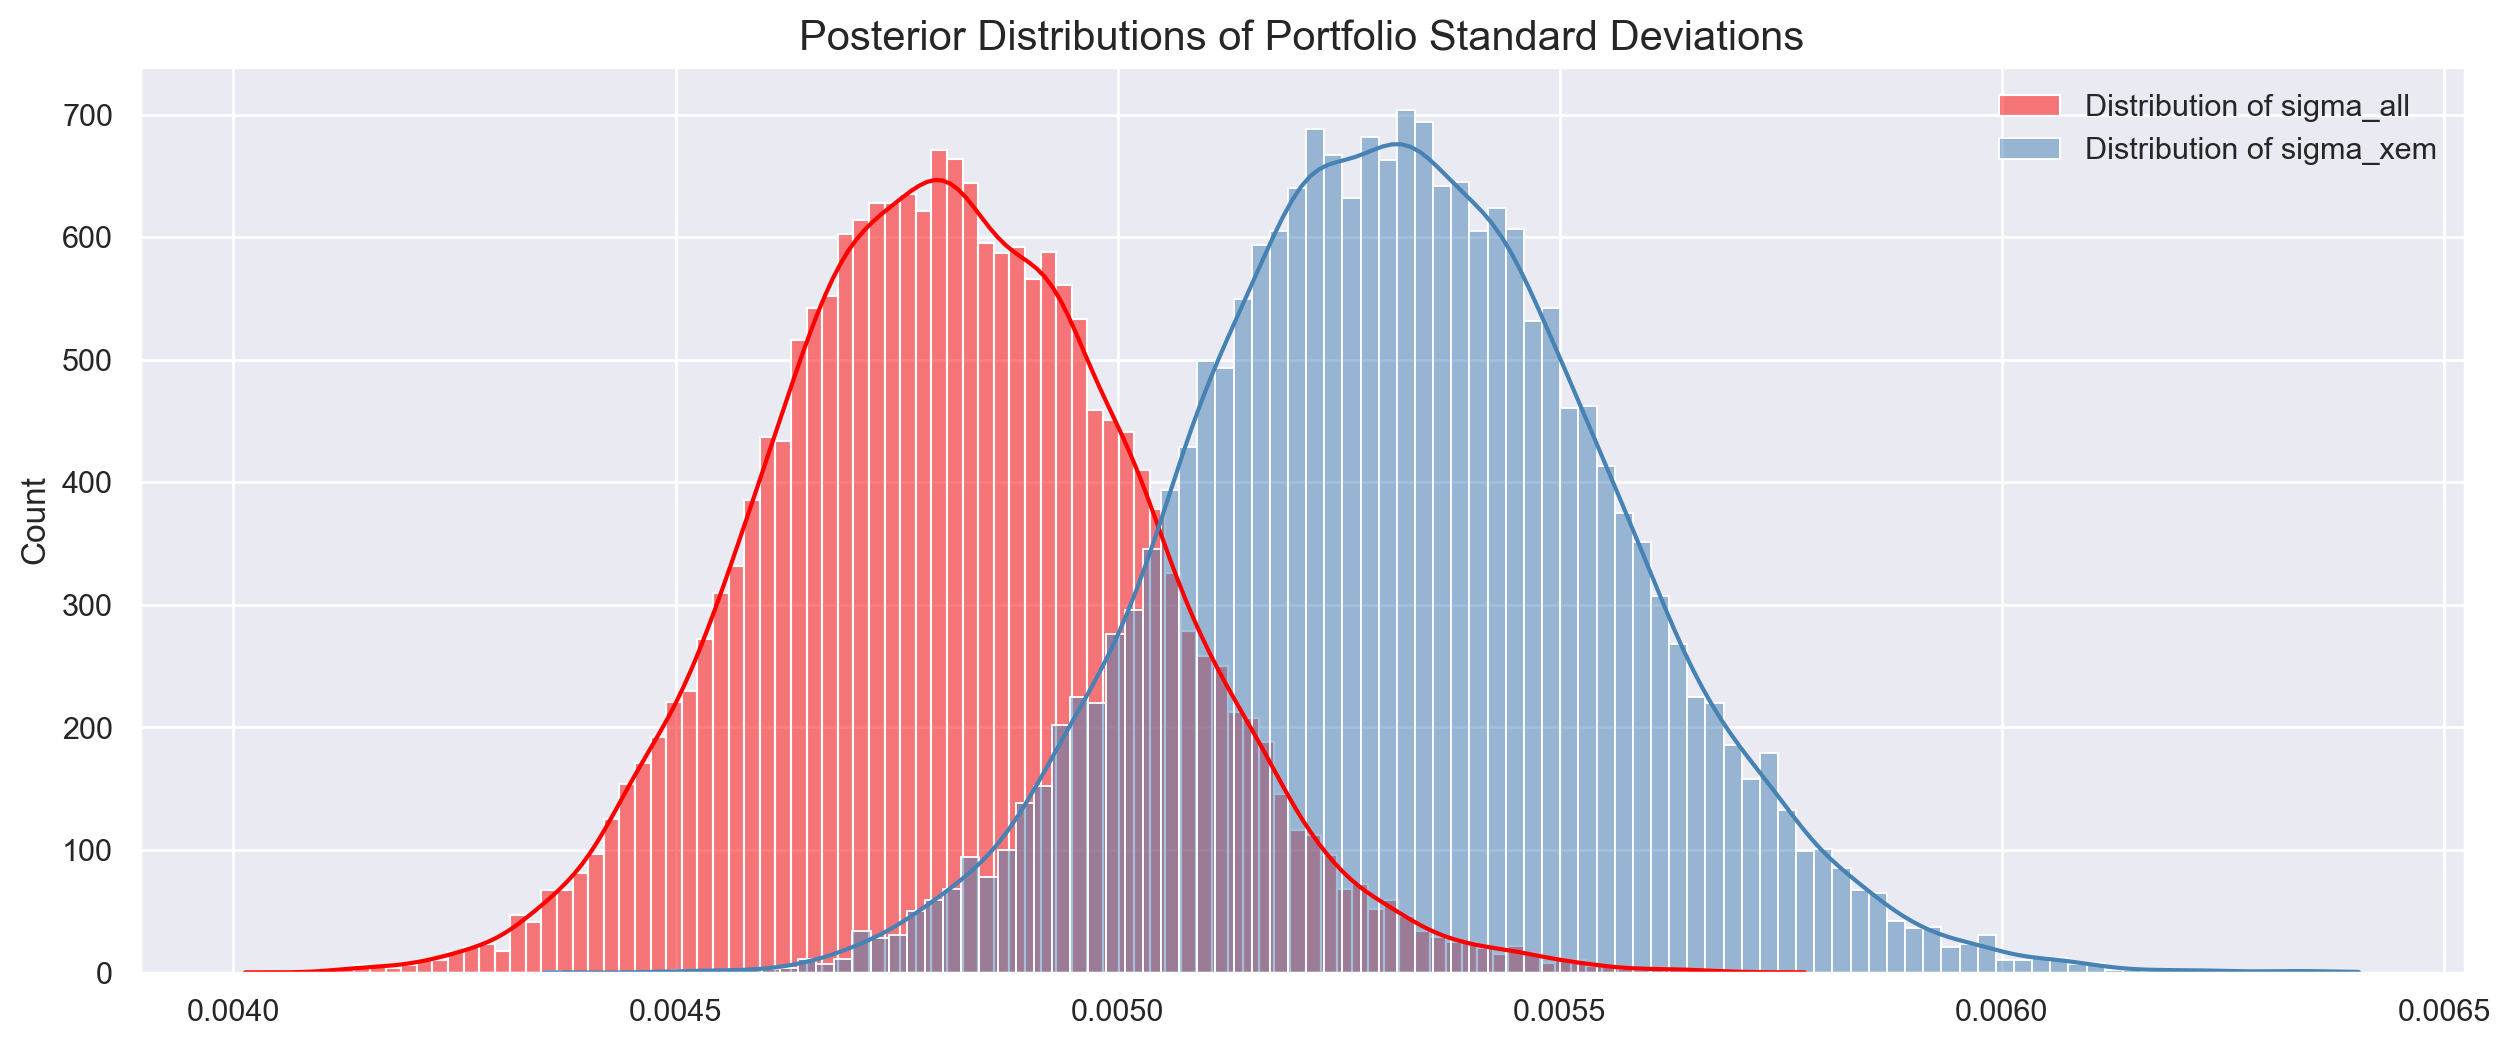

In [74]:
fig, ax = plt.subplots(figsize=(15,6))

sns.histplot(trace2['sigma_all'], bins=100, kde=True, ax=ax, color='red', label='Distribution of sigma_all')
sns.histplot(trace2['sigma_xem'], bins=100, kde=True, ax=ax, color='steelblue', label='Distribution of sigma_xem')
plt.title('Posterior Distributions of Portfolio Standard Deviations', fontsize=15)
plt.legend();

In [75]:
# The point estimates of the annualized standard deviations
print("Mean estimate of the original portfolio volatility is: {:0.6f}".format(trace2['sigma_all'].mean()*(253**0.5)))
print("Mean estimate of the EM-limited portfolio volatility is: {:0.6f}".format(trace2['sigma_xem'].mean()*(253**0.5)))

Mean estimate of the original portfolio volatility is: 0.076656
Mean estimate of the EM-limited portfolio volatility is: 0.084643


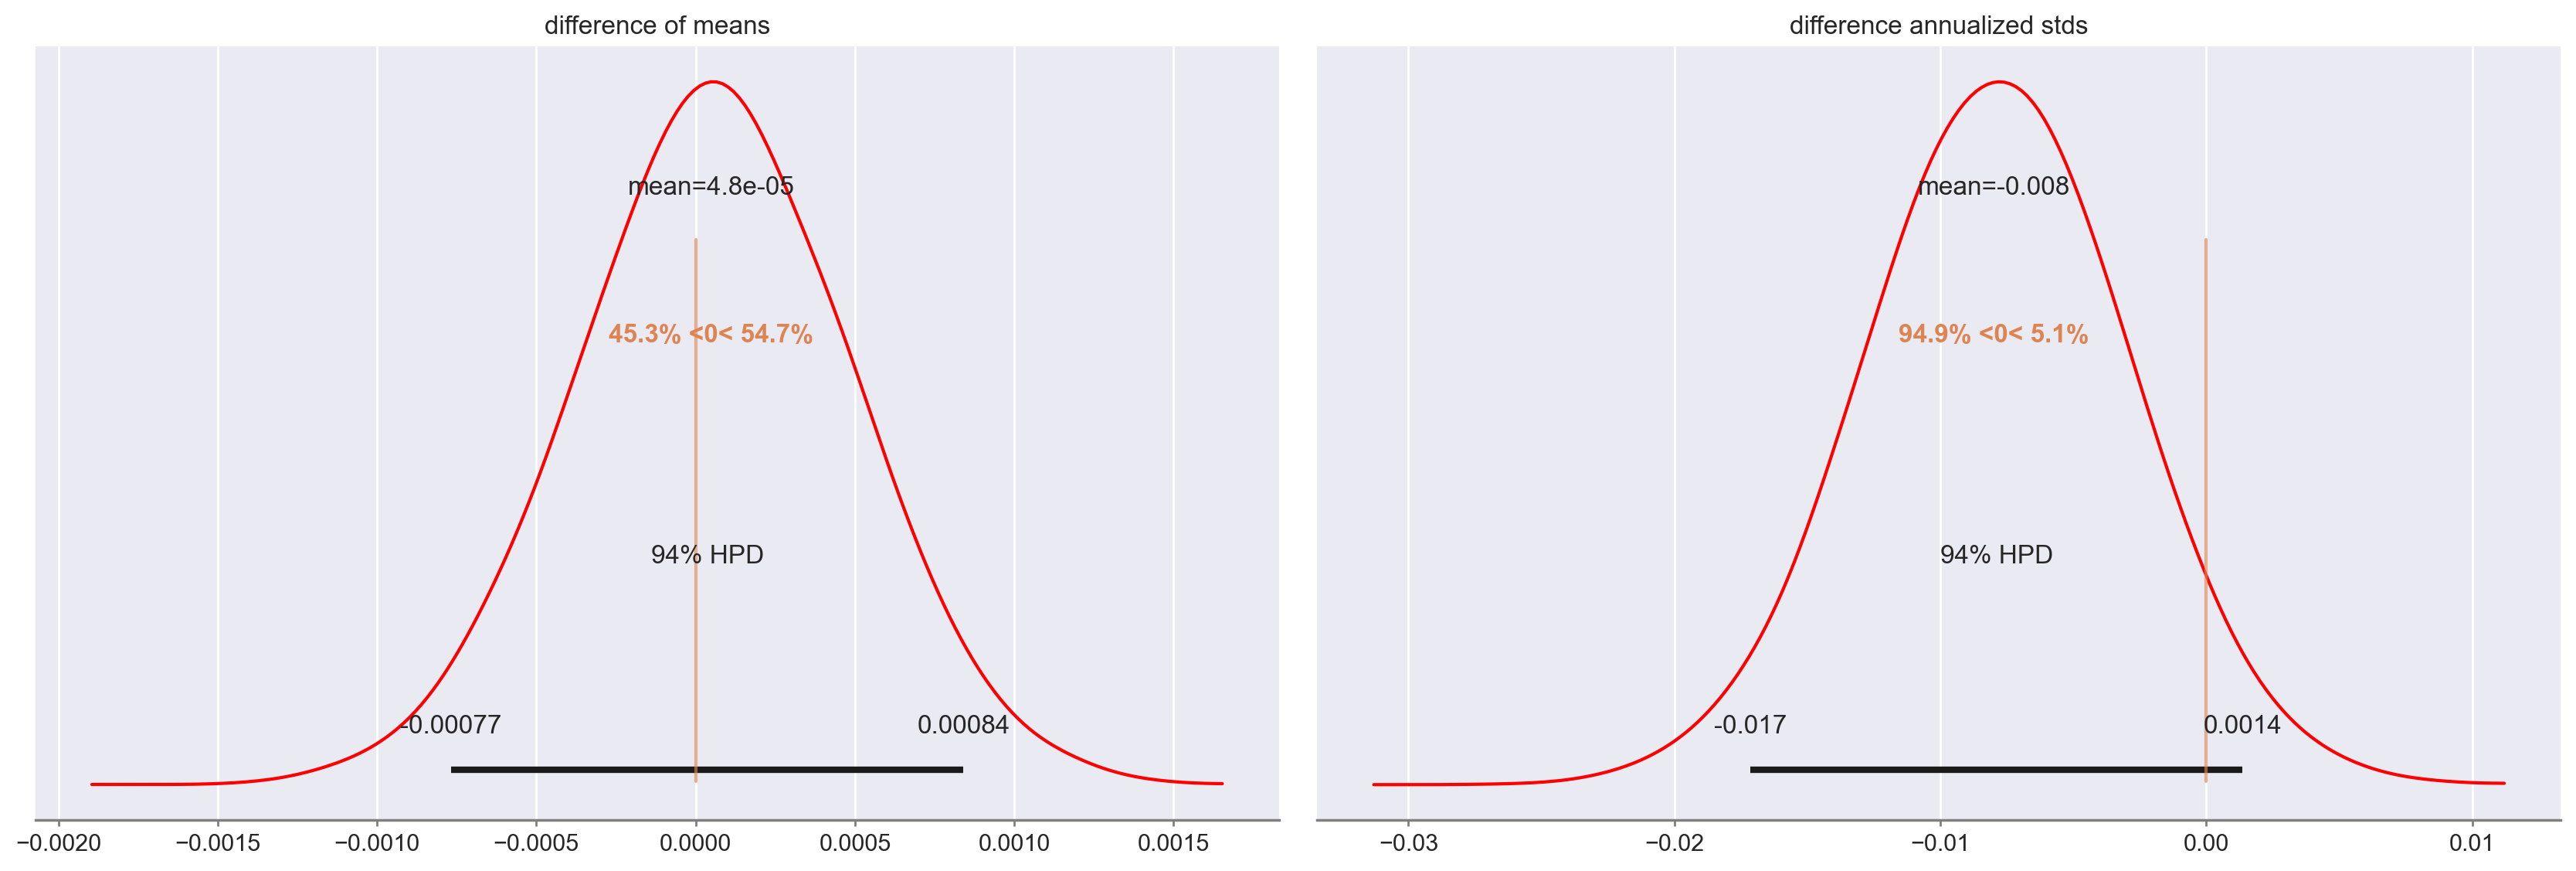

In [76]:
pm.plot_posterior(
    trace2,
    var_names=["difference of means", "difference annualized stds"],
    ref_val=0,
    color="red",
);

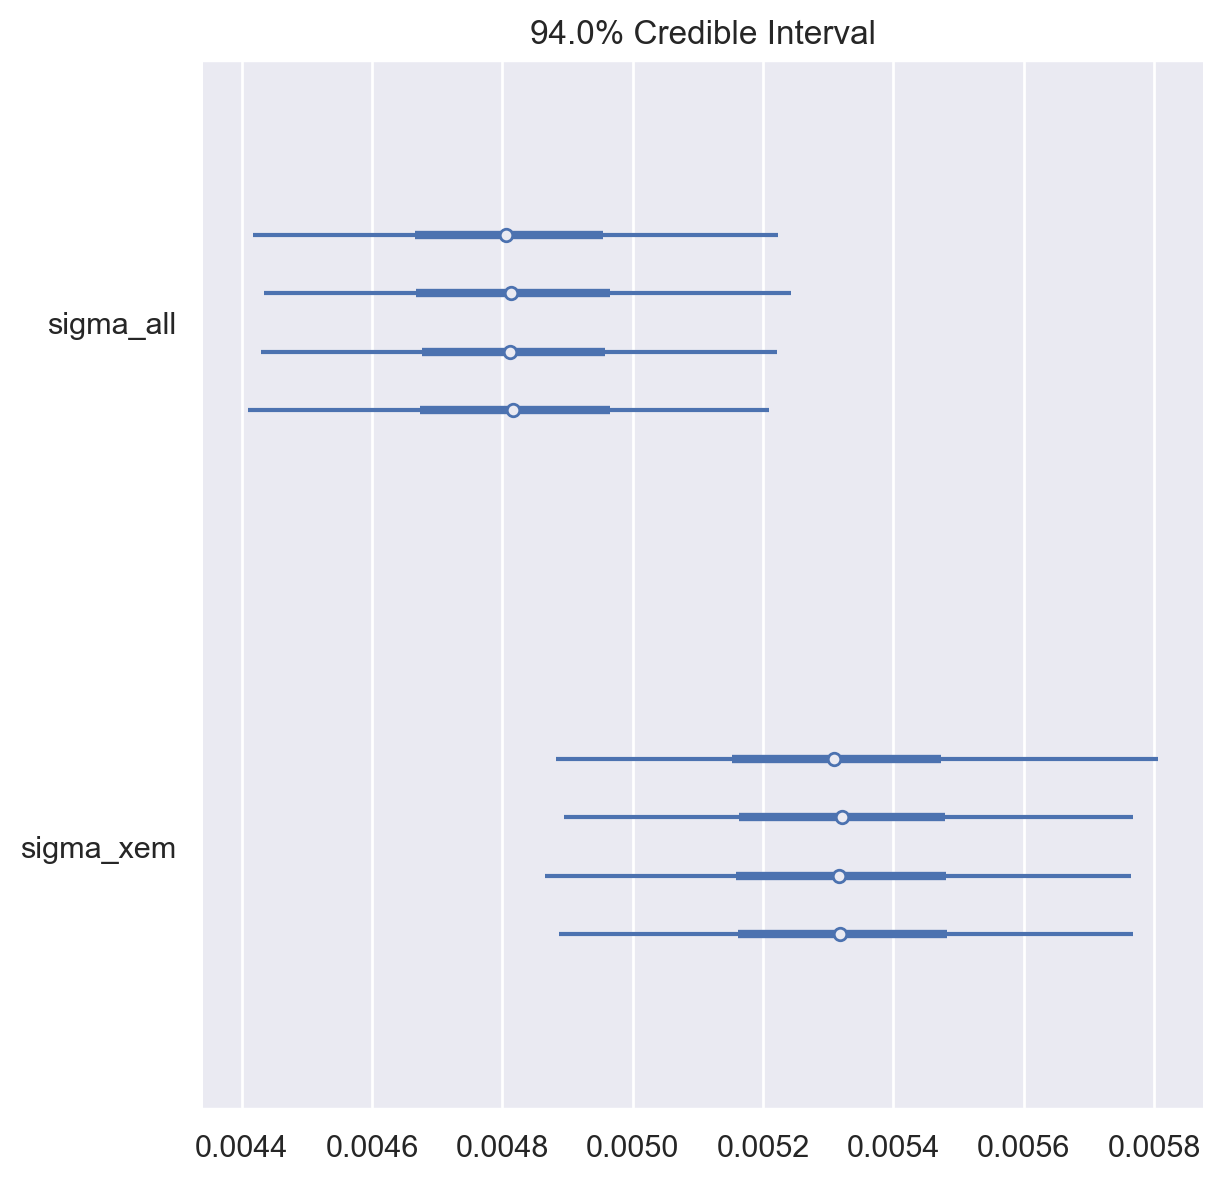

In [77]:
az.plot_forest(trace2, var_names=["sigma_all", "sigma_xem"], r_hat=False);

In [78]:
pm.summary(trace2, varnames=["difference of means", "difference of stds", "difference annualized stds"])

C:\Users\camb7\anaconda3\lib\site-packages\pymc3\stats\__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.9
  "pymc3 3.9".format(old=old, new=new)


mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  \
difference of means         0.000  0.000  -0.001    0.001        0.0      0.0   
difference of stds         -0.001  0.000  -0.001    0.000        0.0      0.0   
difference annualized stds -0.008  0.005  -0.017    0.001        0.0      0.0   

                            ess_mean   ess_sd  ess_bulk  ess_tail  r_hat  
difference of means          27396.0  10766.0   27423.0   16486.0    1.0  
difference of stds           30702.0  23499.0   30722.0   16299.0    1.0  
difference annualized stds   30702.0  23499.0   30722.0   16299.0    1.0